In [1]:
import torch

from IPython.display import Image, clear_output
import yaml
from IPython.core.magic import register_line_cell_magic
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Code referred and used from https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov5-object-detection-on-custom-data.ipynb

In [3]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16575, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 16575 (delta 28), reused 37 (delta 18), pack-reused 16522
Receiving objects: 100% (16575/16575), 15.10 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (11385/11385), done.


In [4]:
!pip install -qr /content/yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [5]:
#!curl -L "/content/drive/MyDrive/Archive.zip" > Archive.zip; unzip Archive.zip; rm Archive.zip
#!unzip Archive.zip

In [5]:
%cat /content/drive/MyDrive/DeepLearning/data.yaml

train: /content/drive/MyDrive/DeepLearning/train/images
val: /content/drive/MyDrive/DeepLearning/test/images

nc: 11
names: ['fingerup','fingerdown','thumbsup','thumbsdown','fingerleft','fingerright','ok','closedfist','peace sign','rockon sign','L']



In [6]:

with open("/content/drive/MyDrive/DeepLearning/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
num_classes

'11'

In [8]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [9]:
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
%%time
!python /content/yolov5/train.py --img 480 --batch 64 --epochs 200 --data '/content/drive/MyDrive/DeepLearning/data.yaml' --cfg /content/yolov5/models/custom_yolov5s.yaml --weights '/content/yolov5/yolov5s.pt' --name yolov5s_results  --cache


2024-04-29 23:26:20.290258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 23:26:20.290303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 23:26:20.291806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/yolov5/yolov5s.pt, cfg=/content/yolov5/models/custom_yolov5s.yaml, data=/content/drive/MyDrive/DeepLearning/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=64, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resu

In [24]:
 %%time
!python /content/yolov5/train.py --img 600 --batch 64 --epochs 200 --data '/content/drive/MyDrive/DeepLearning/data.yaml' --cfg /content/yolov5/models/custom_yolov5s.yaml --weights '/content/yolov5/yolov5s.pt' --name yolov5s_results  --cache


2024-04-30 00:34:15.133700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 00:34:15.133752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 00:34:15.135028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/yolov5/yolov5s.pt, cfg=/content/yolov5/models/custom_yolov5s.yaml, data=/content/drive/MyDrive/DeepLearning/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=64, imgsz=600, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None

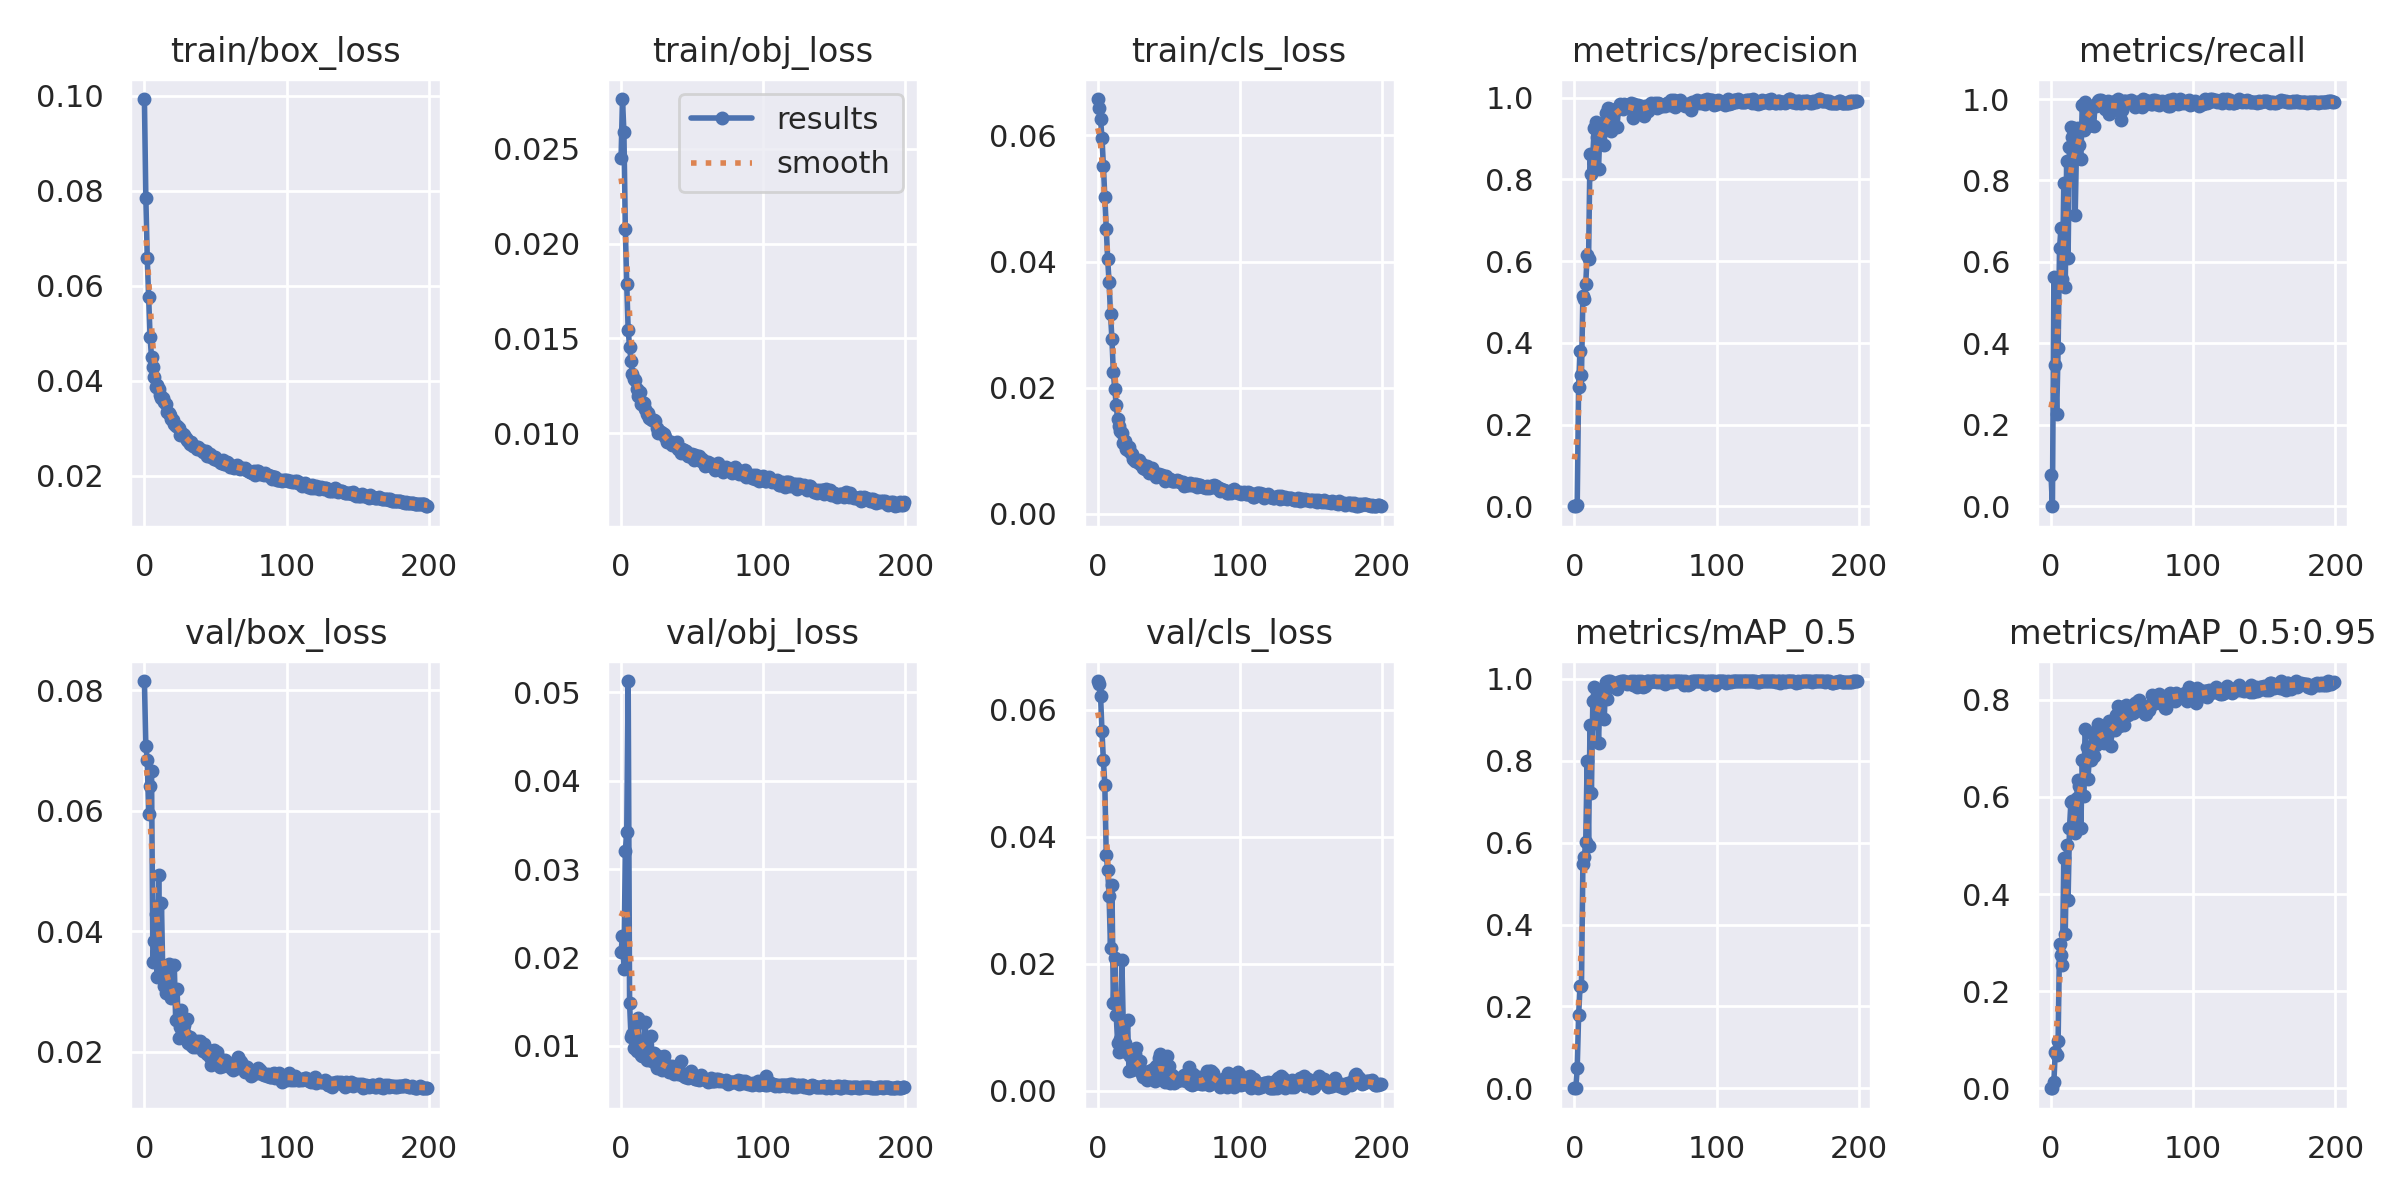

In [26]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)

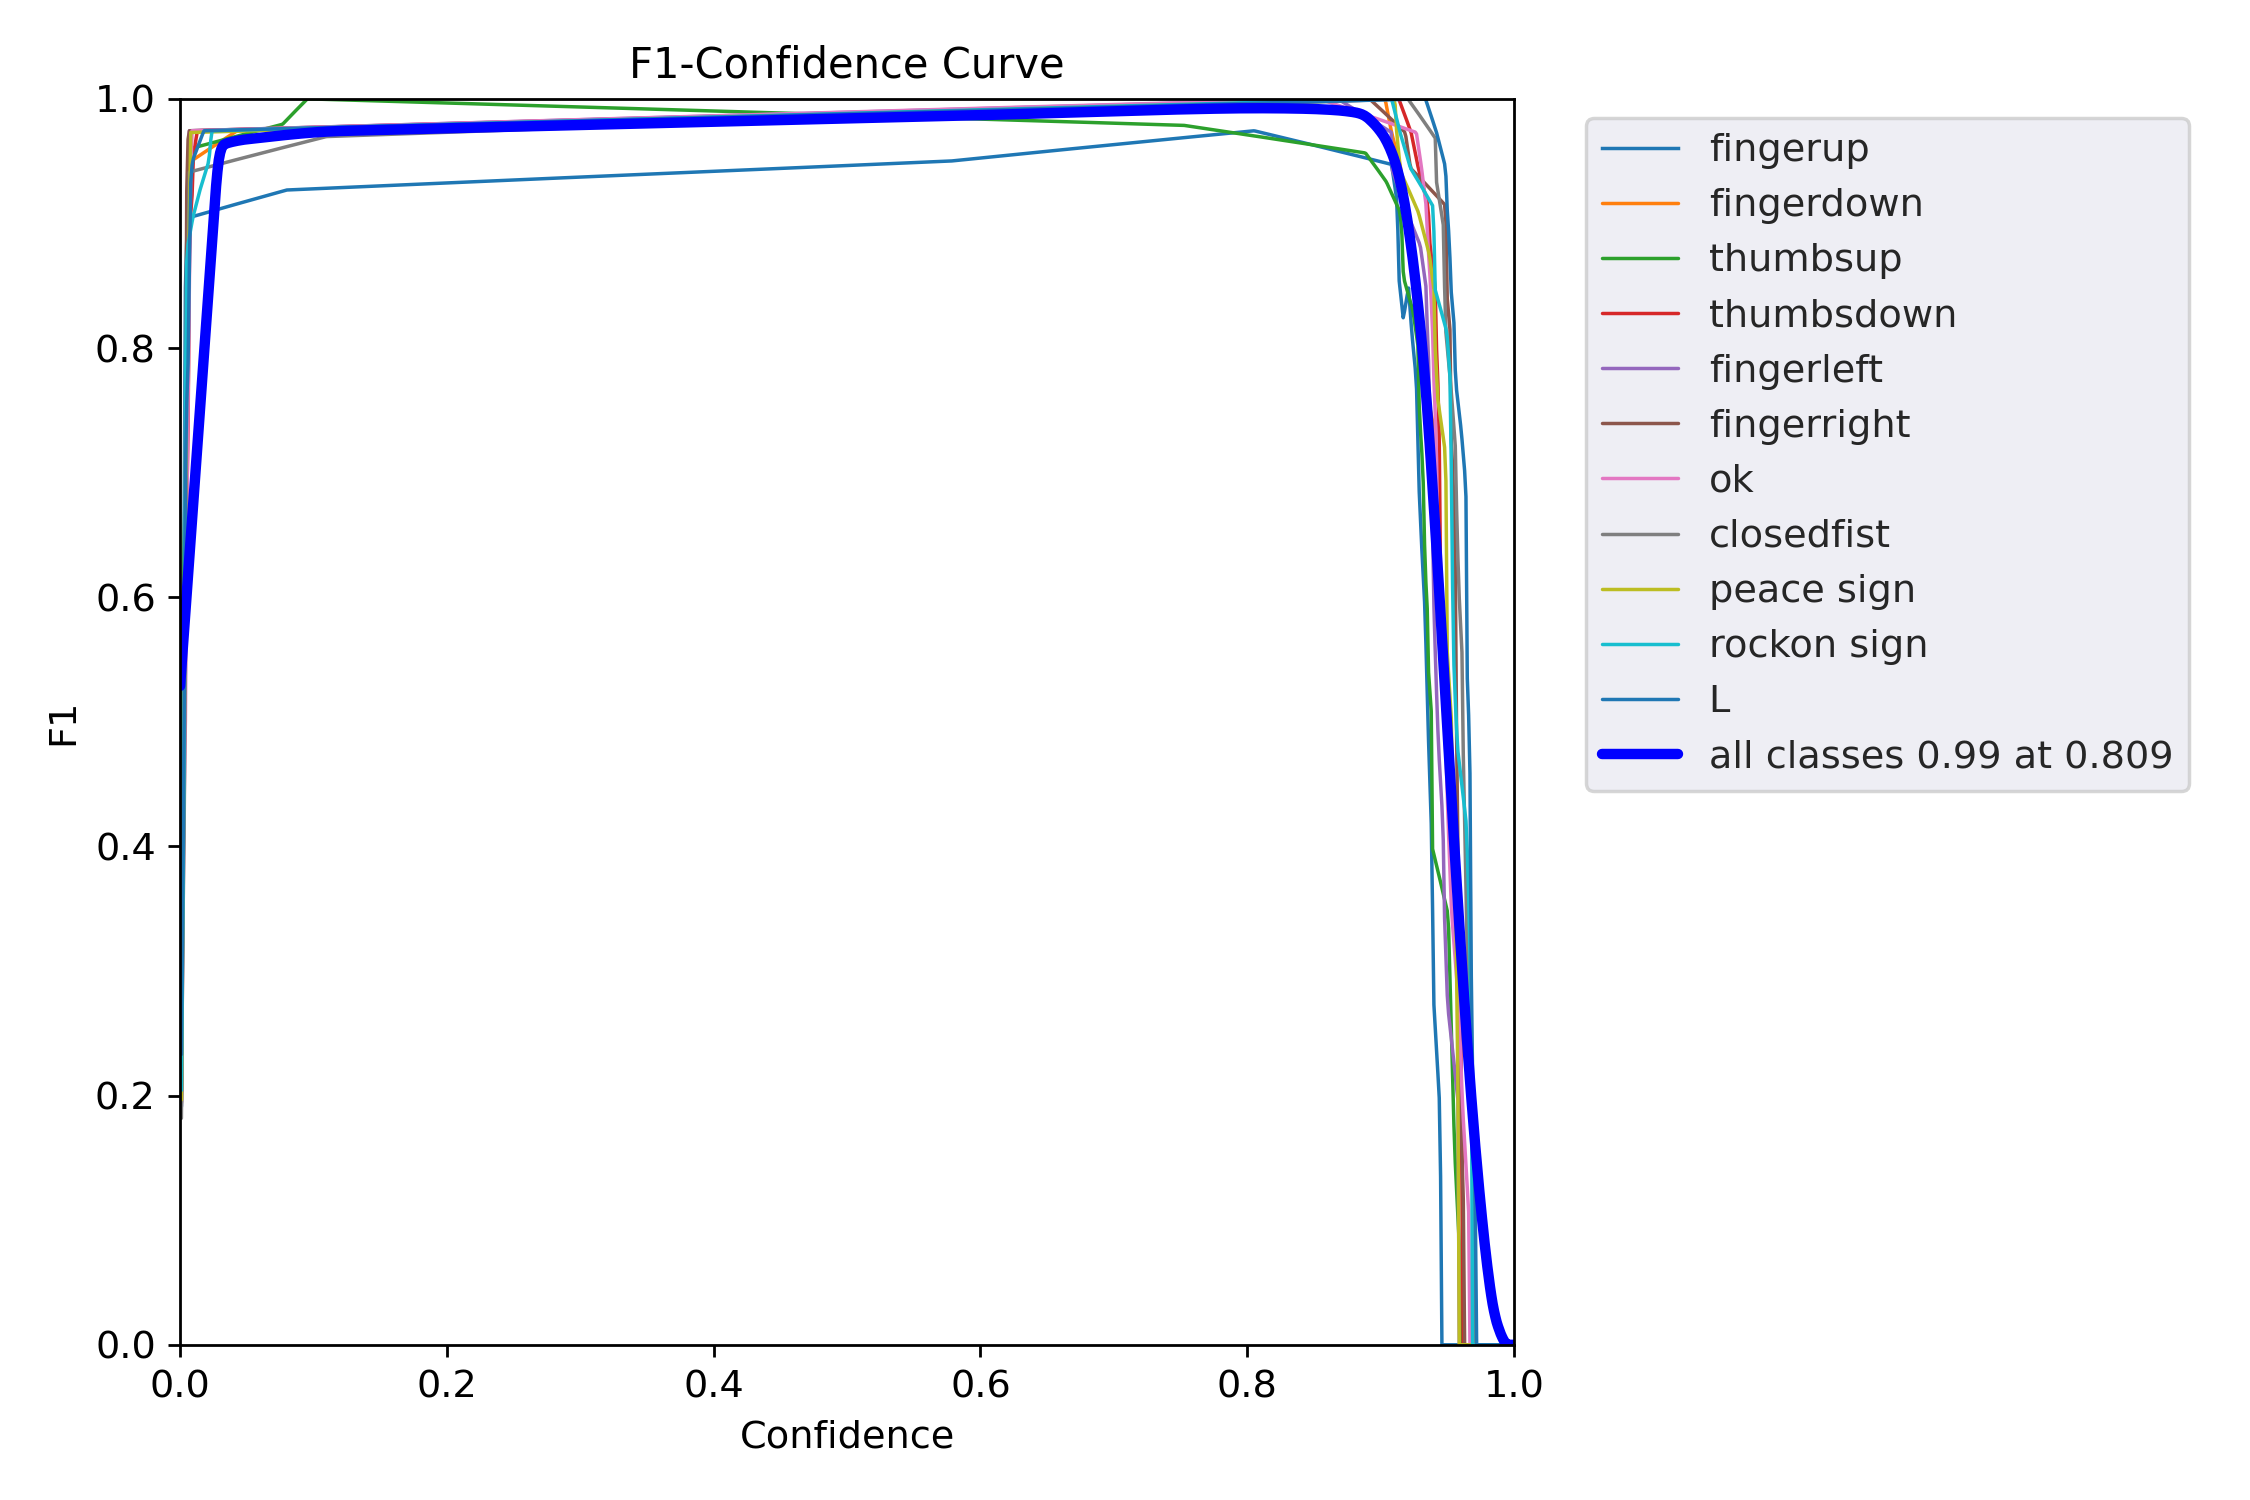

In [27]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/F1_curve.png', width=1000)

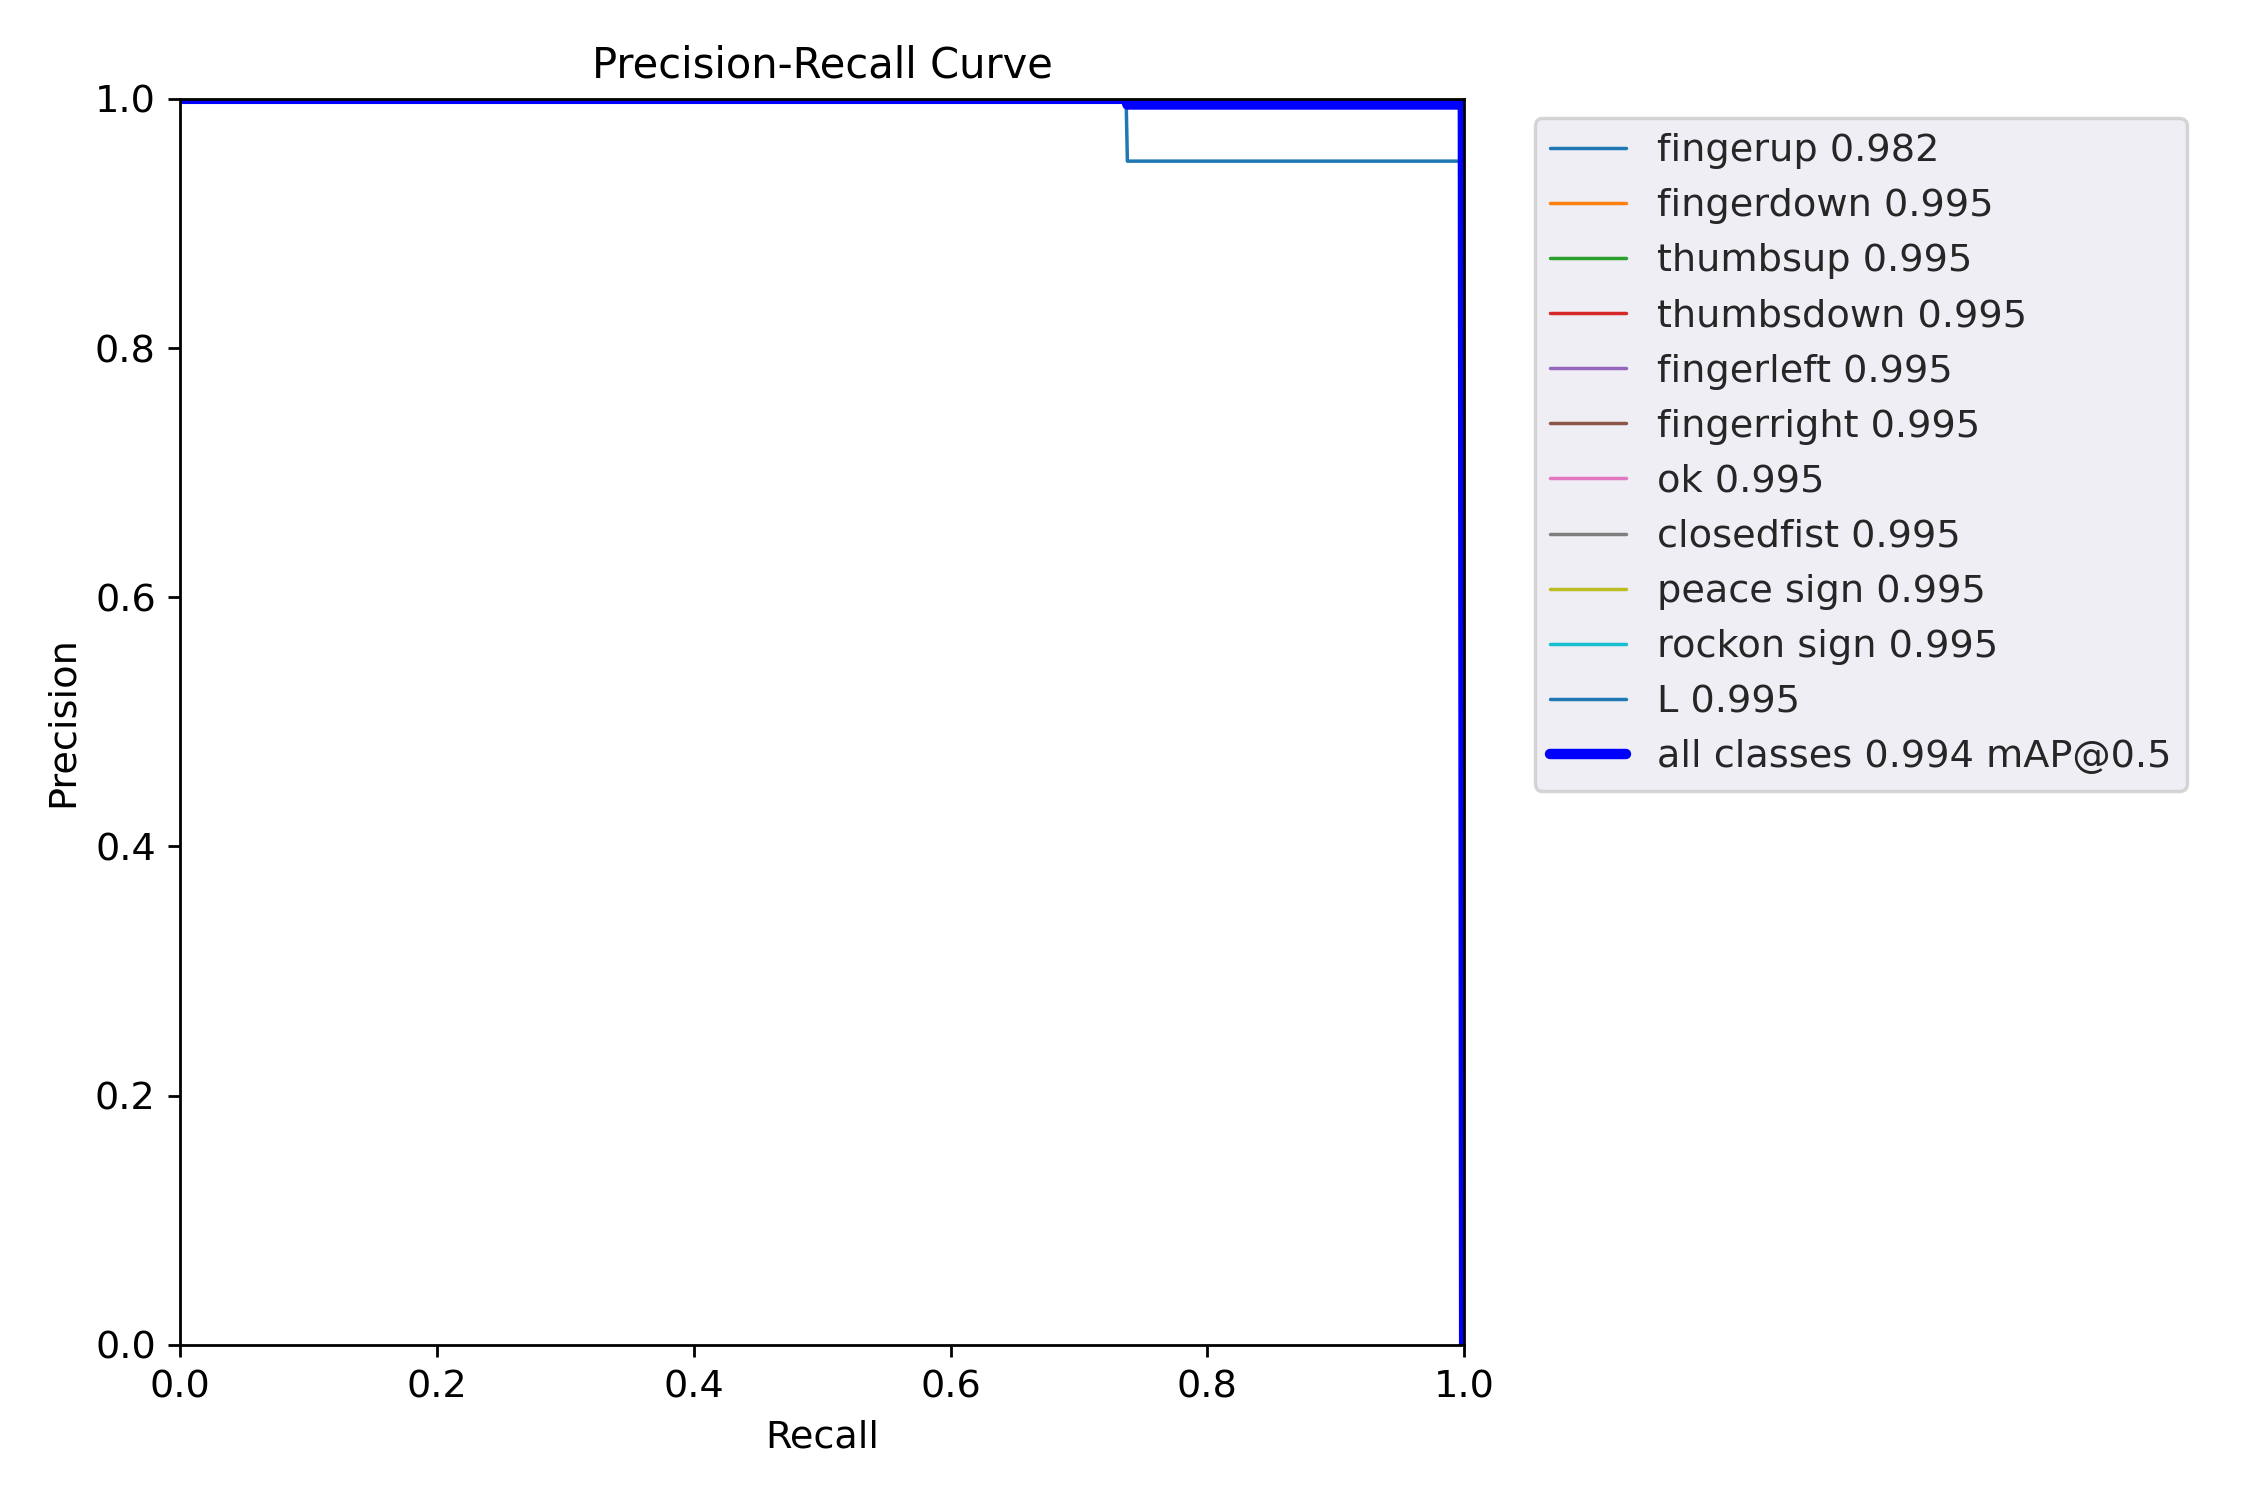

In [28]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/PR_curve.png', width=1000)

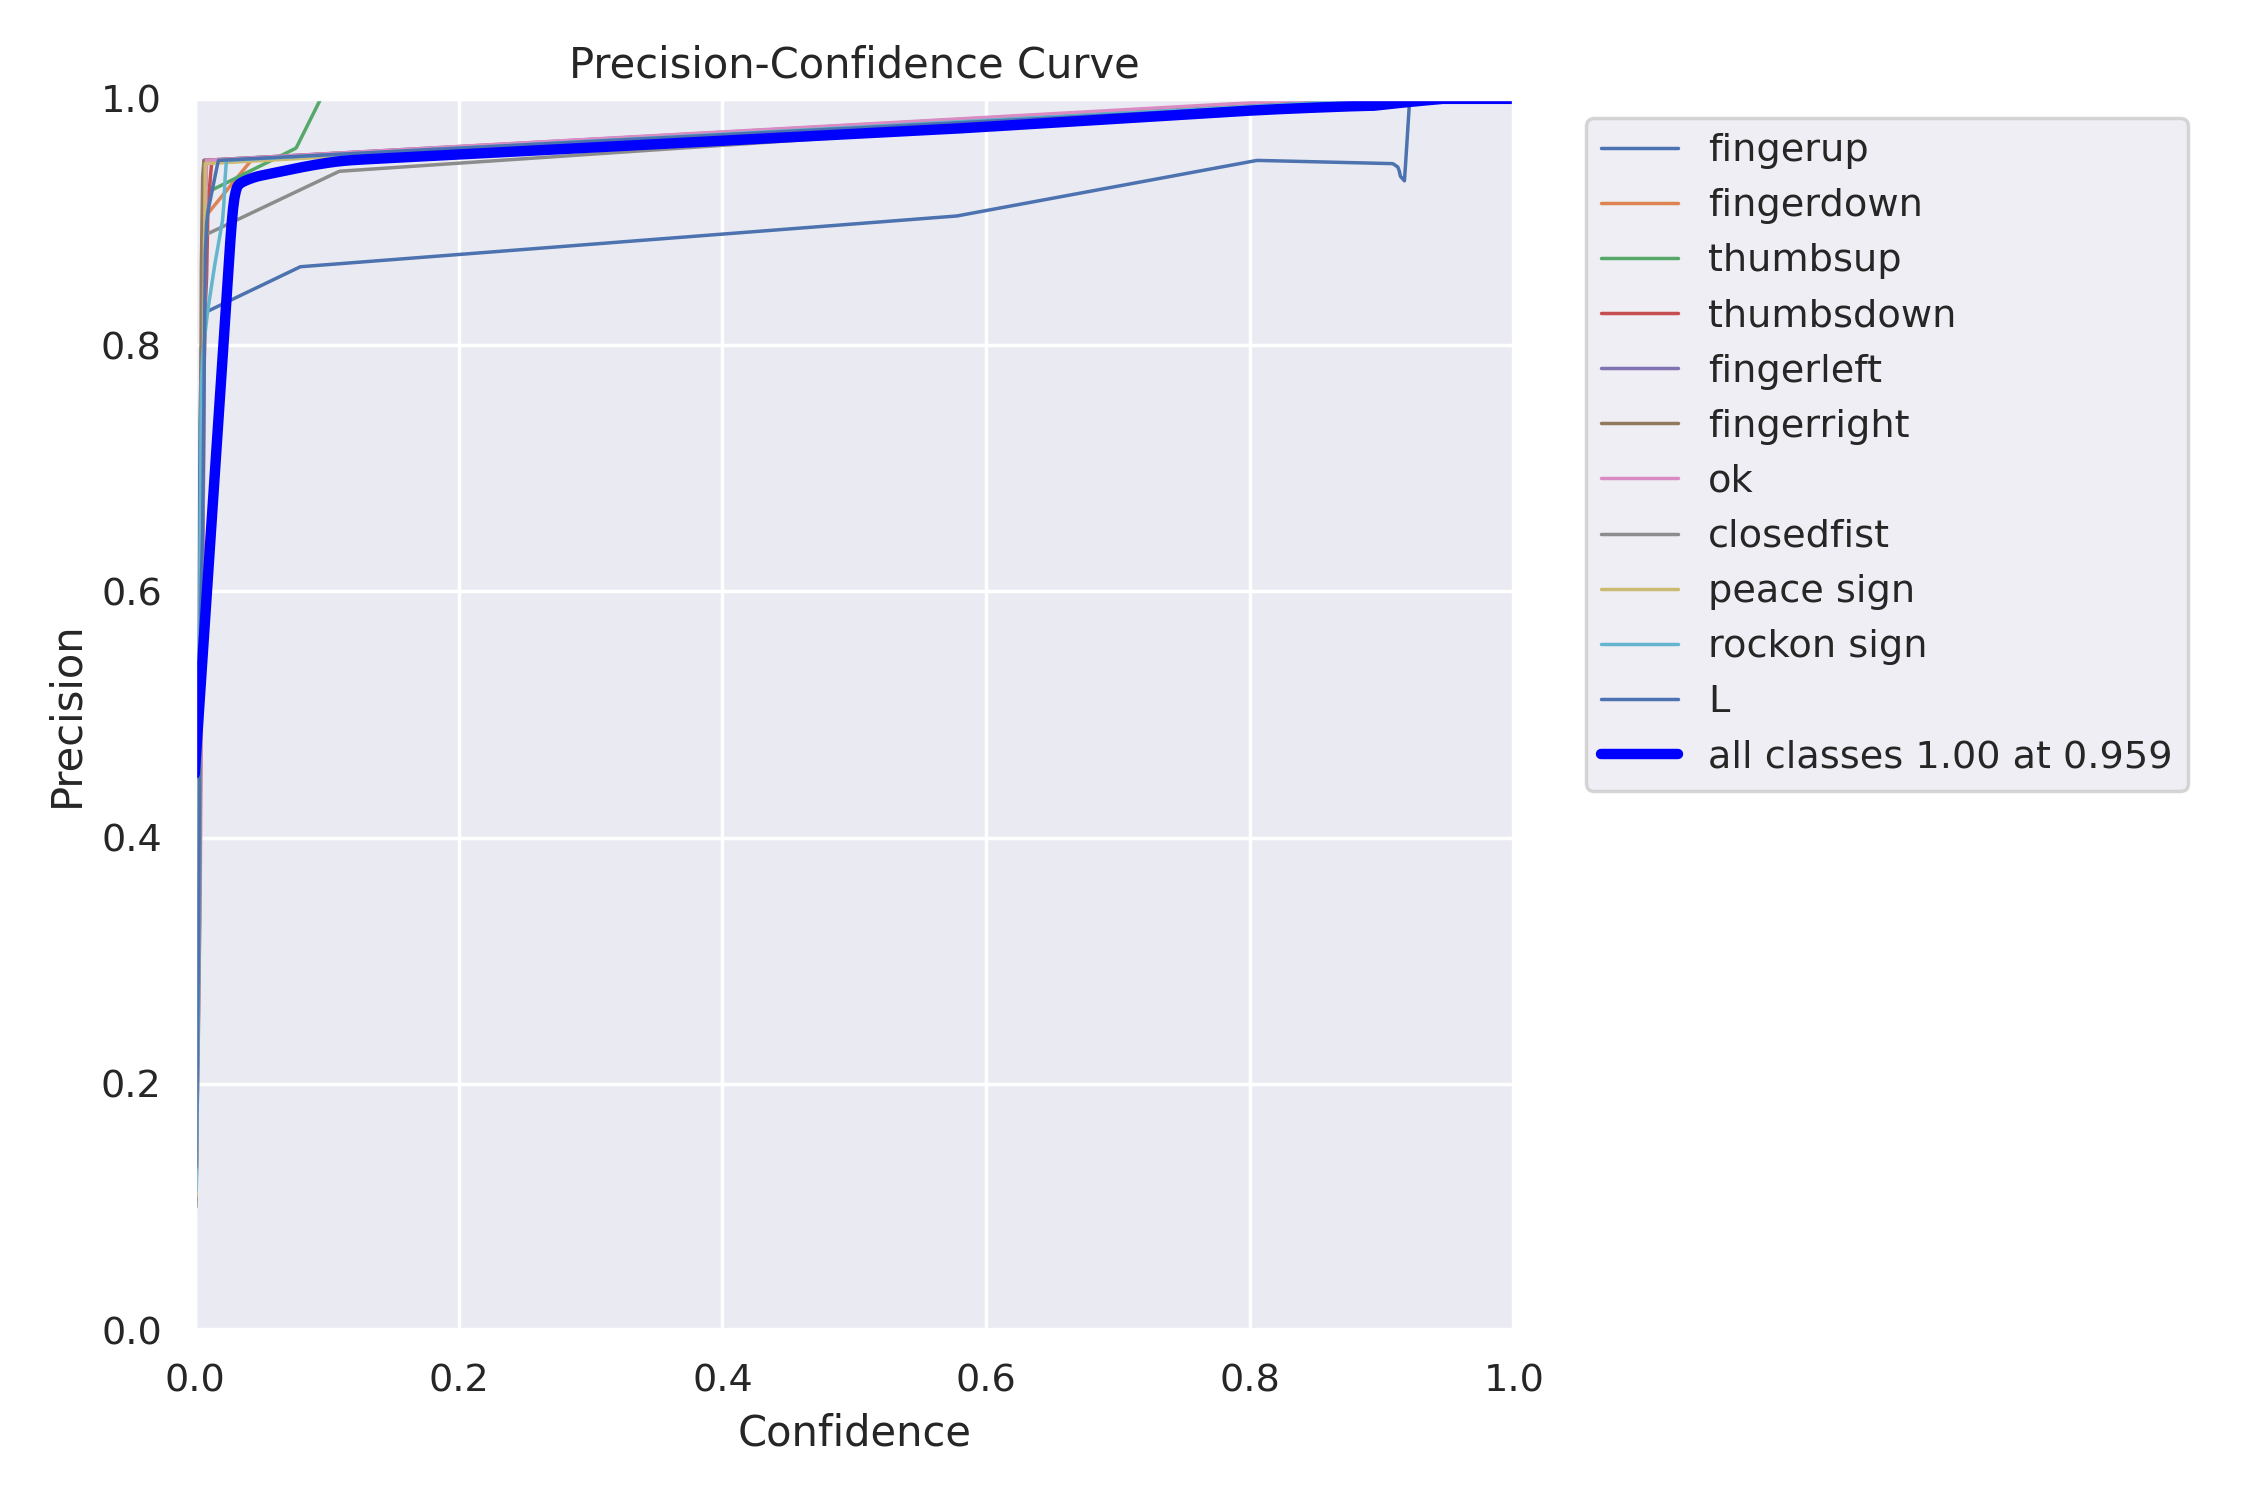

In [17]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/P_curve.png', width=1000)

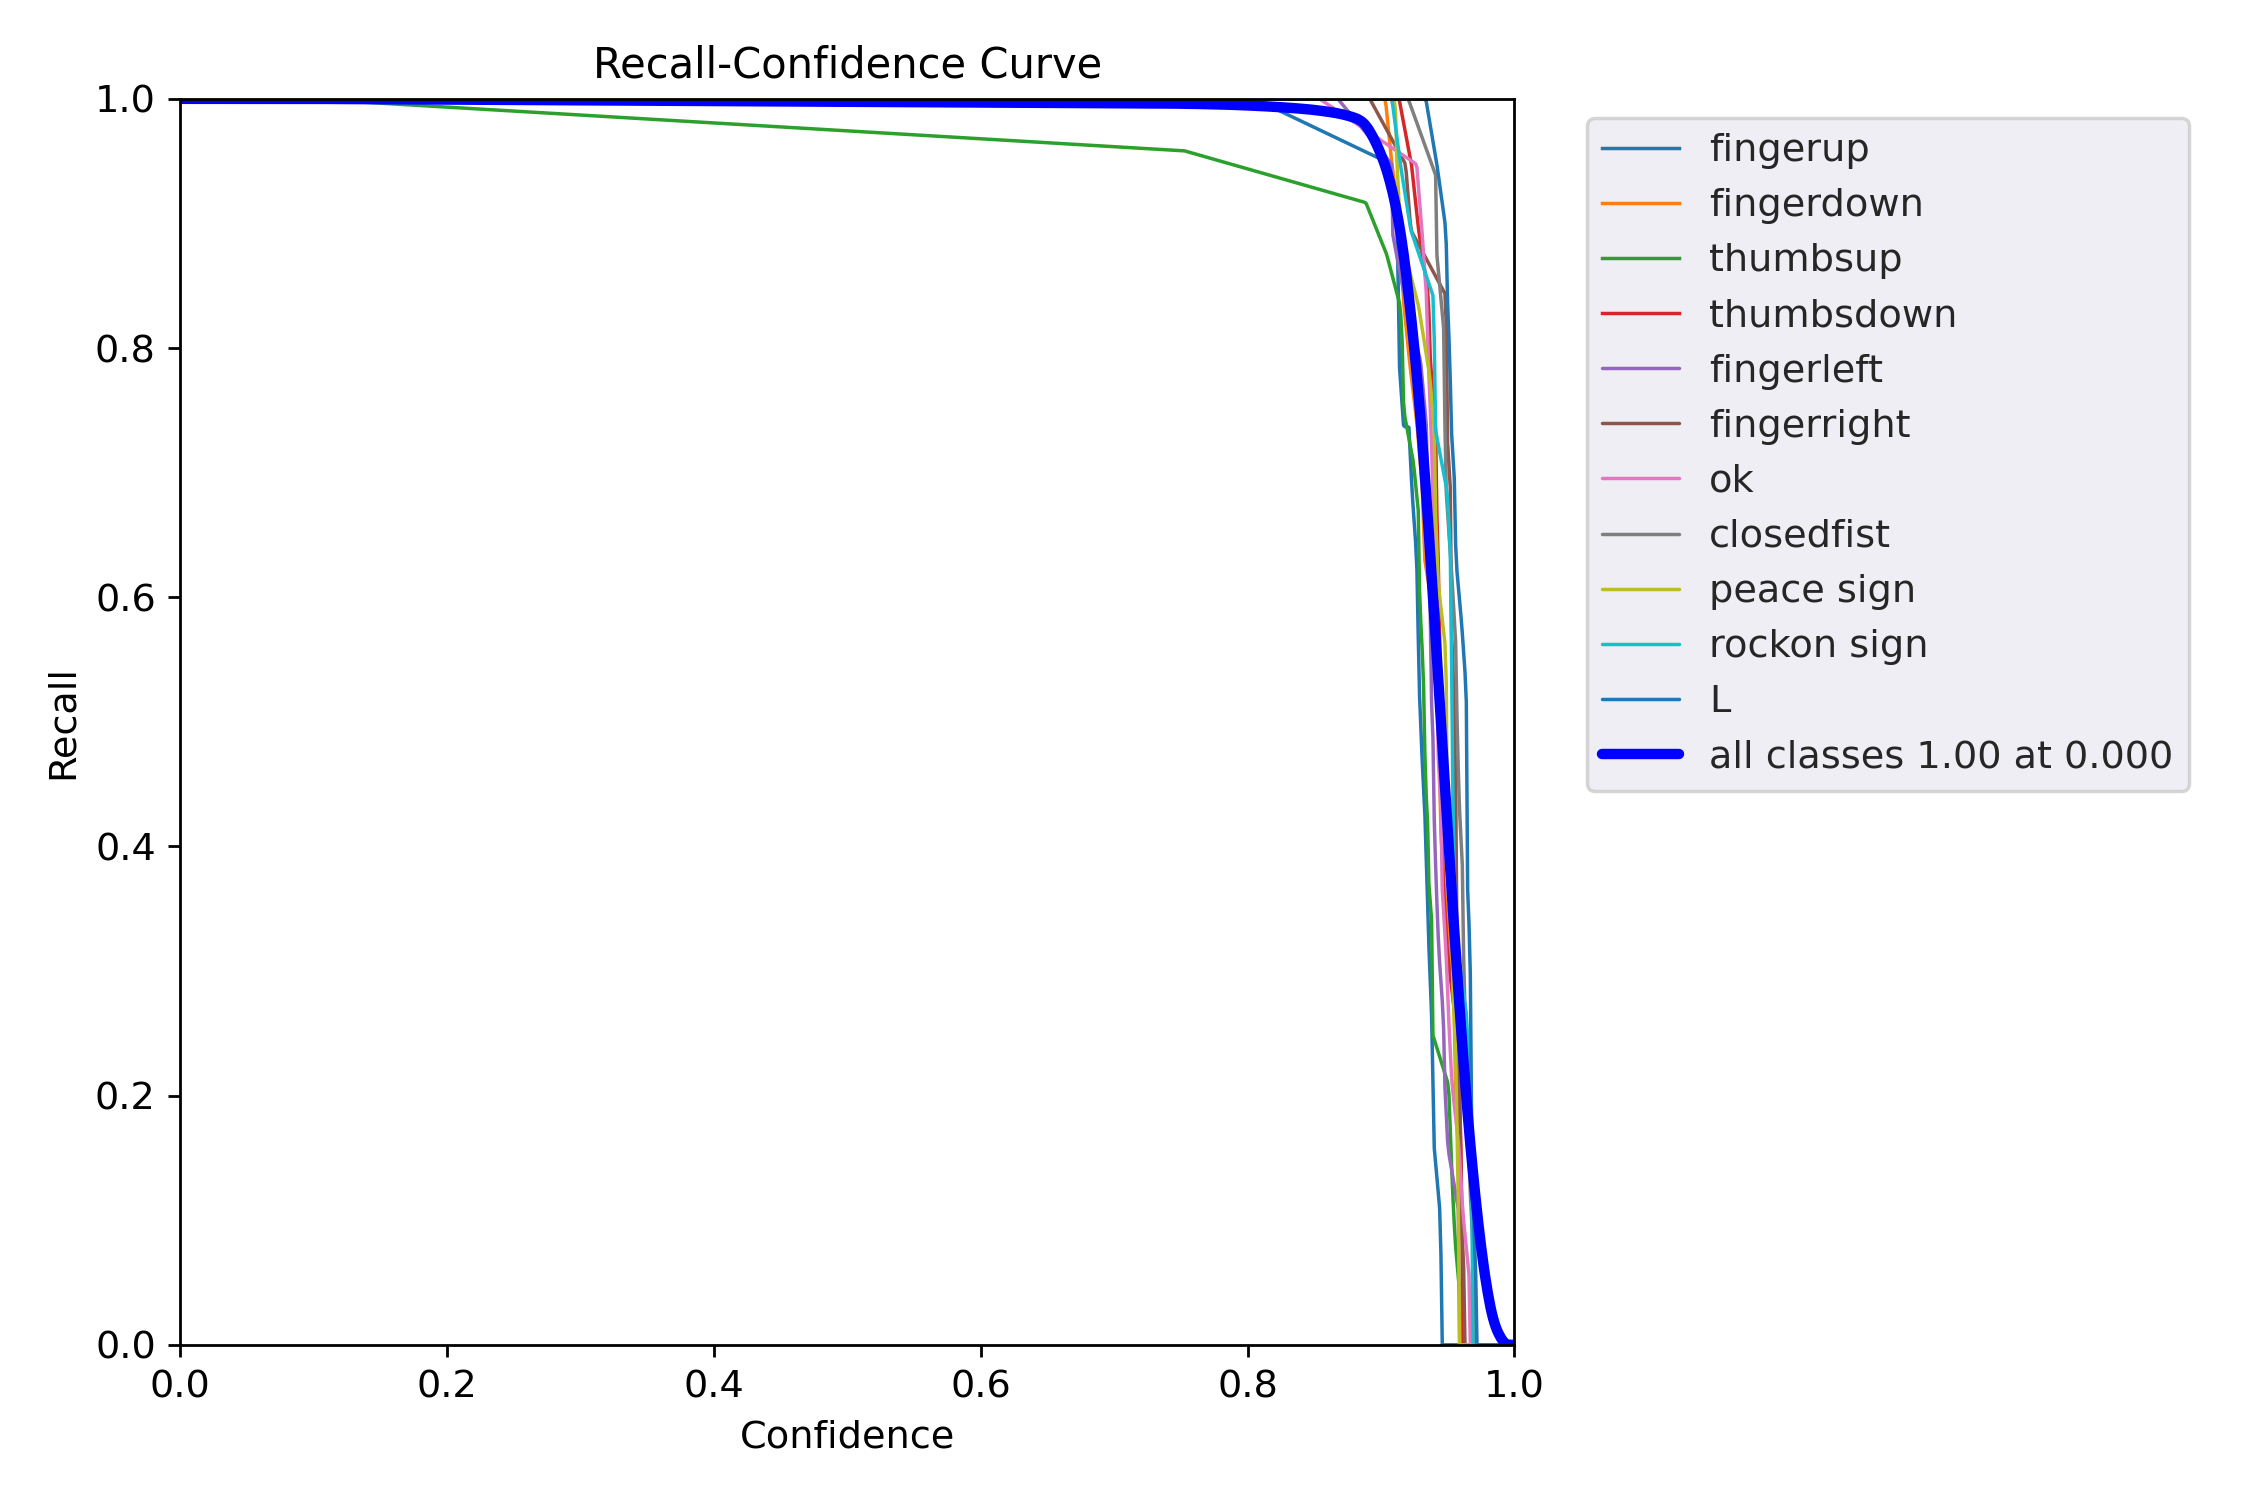

In [29]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/R_curve.png', width=1000)

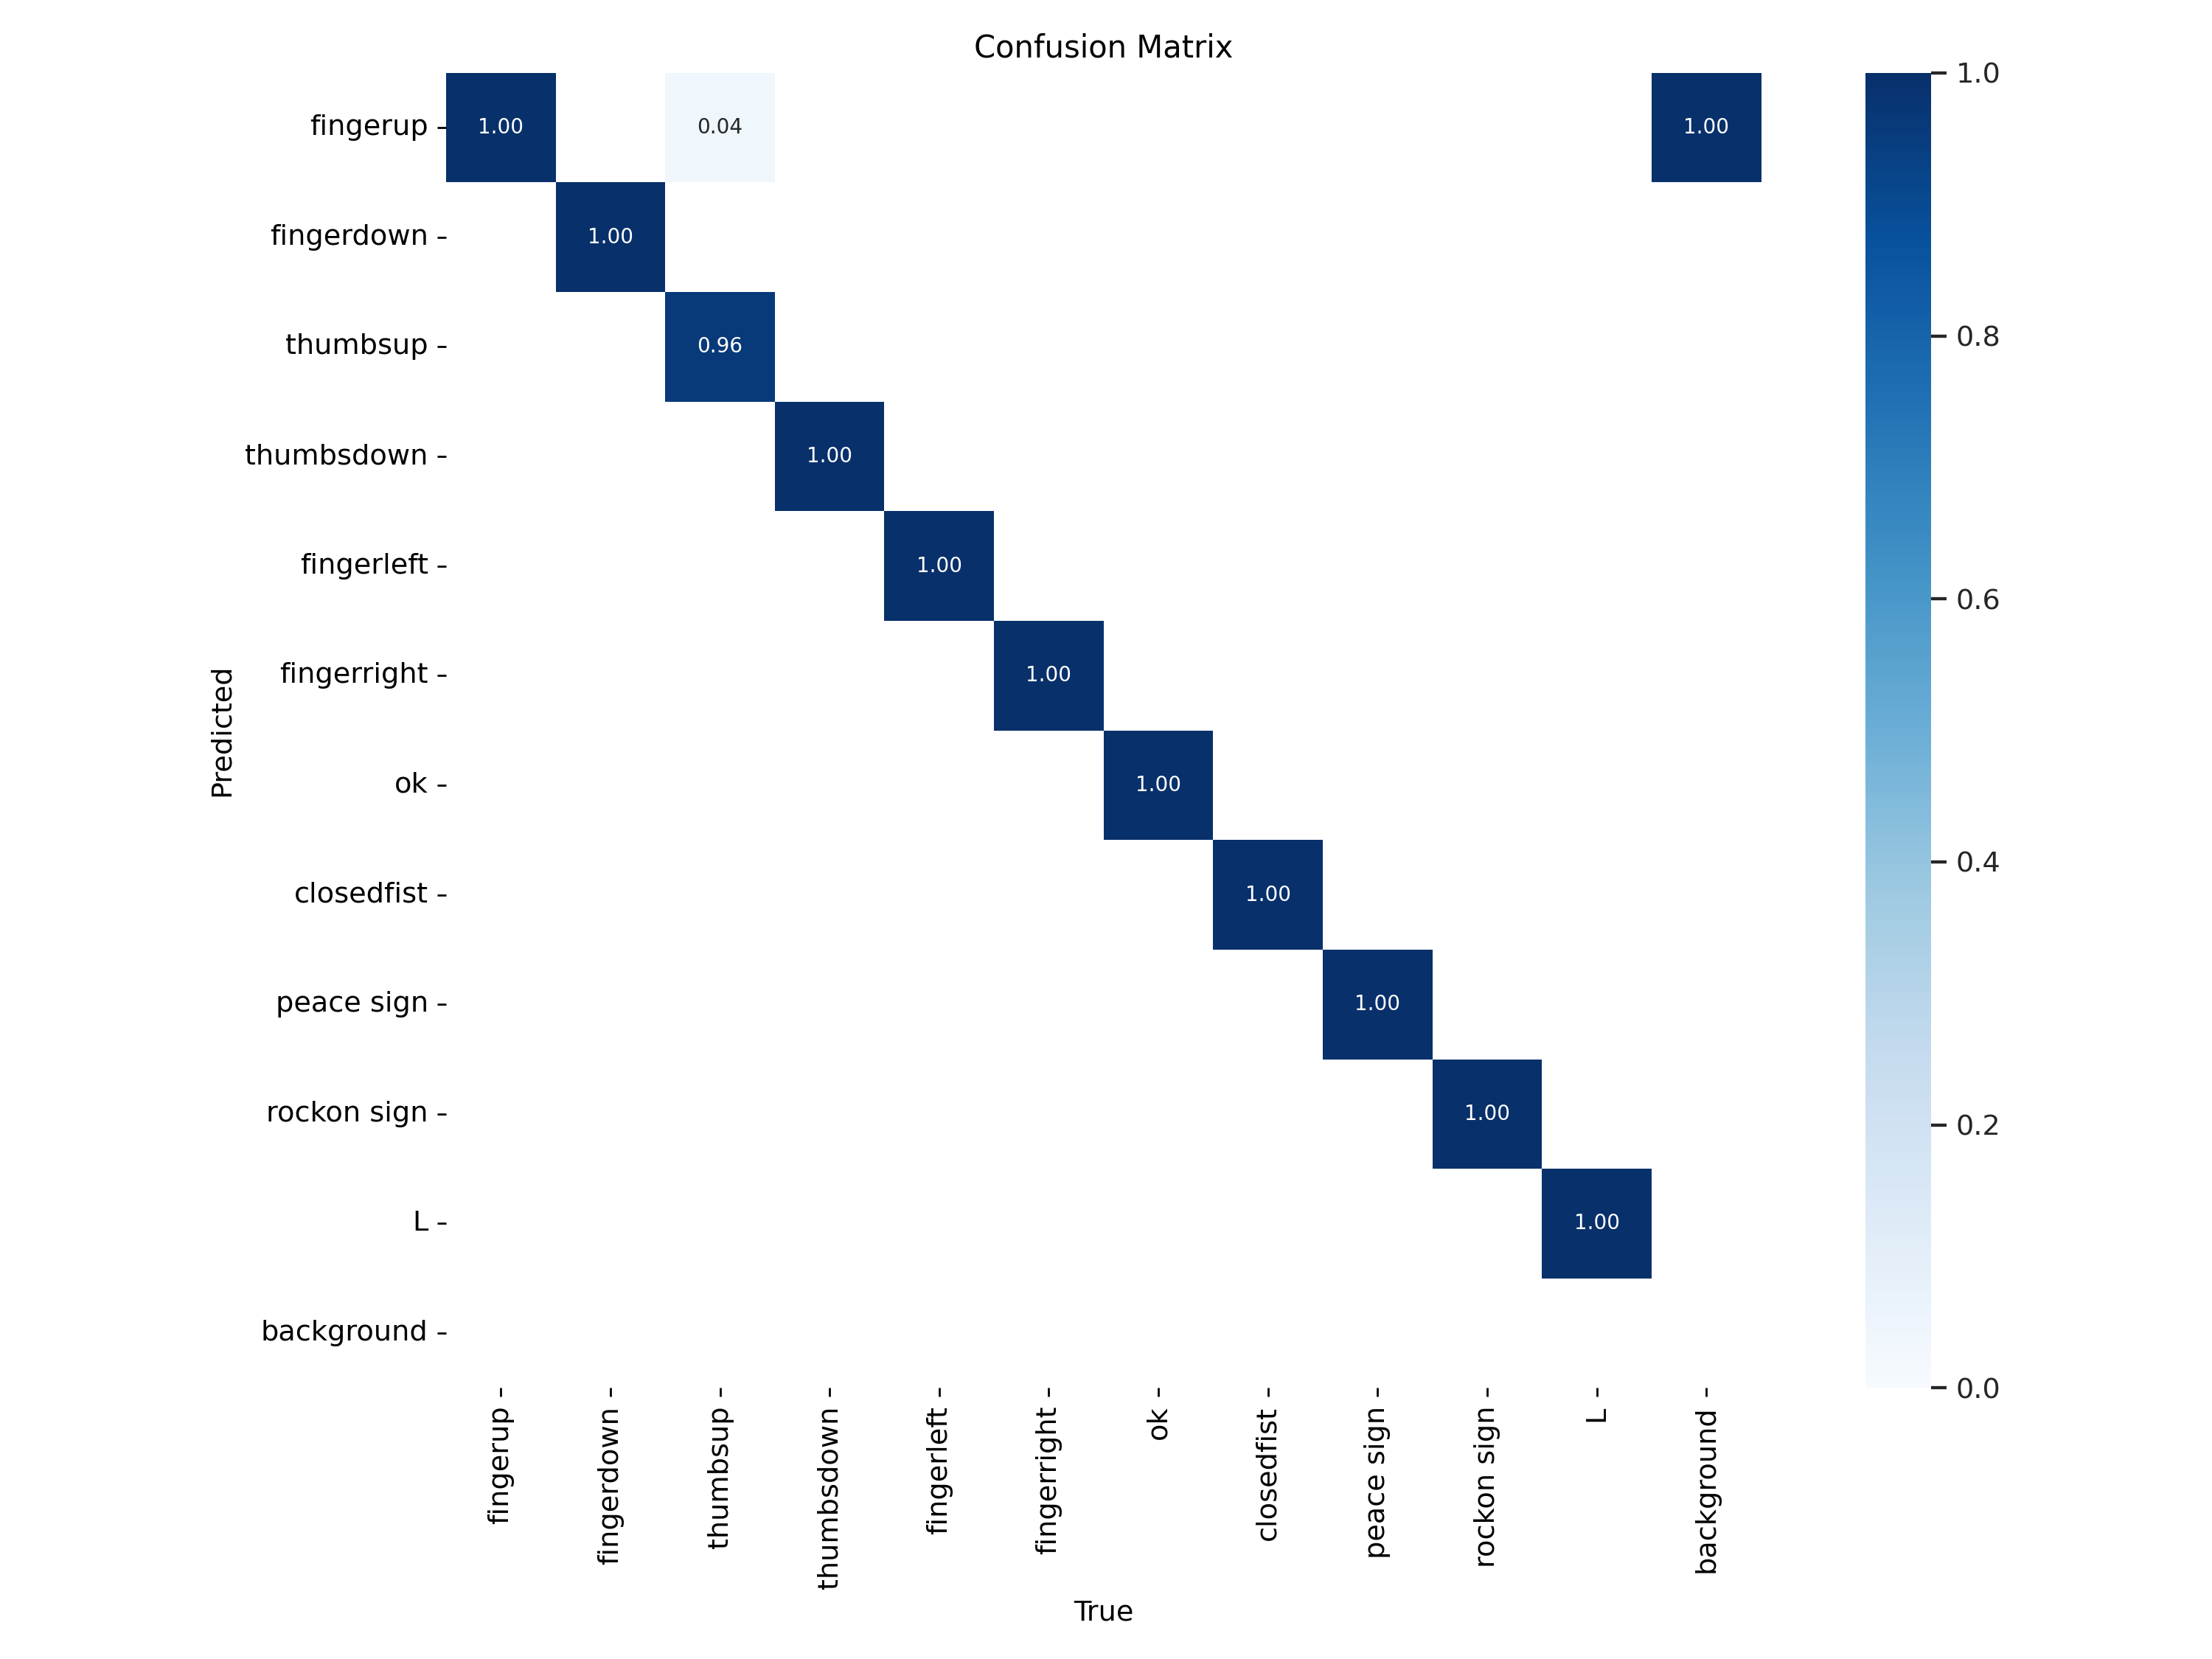

In [30]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/confusion_matrix.png', width=1000)

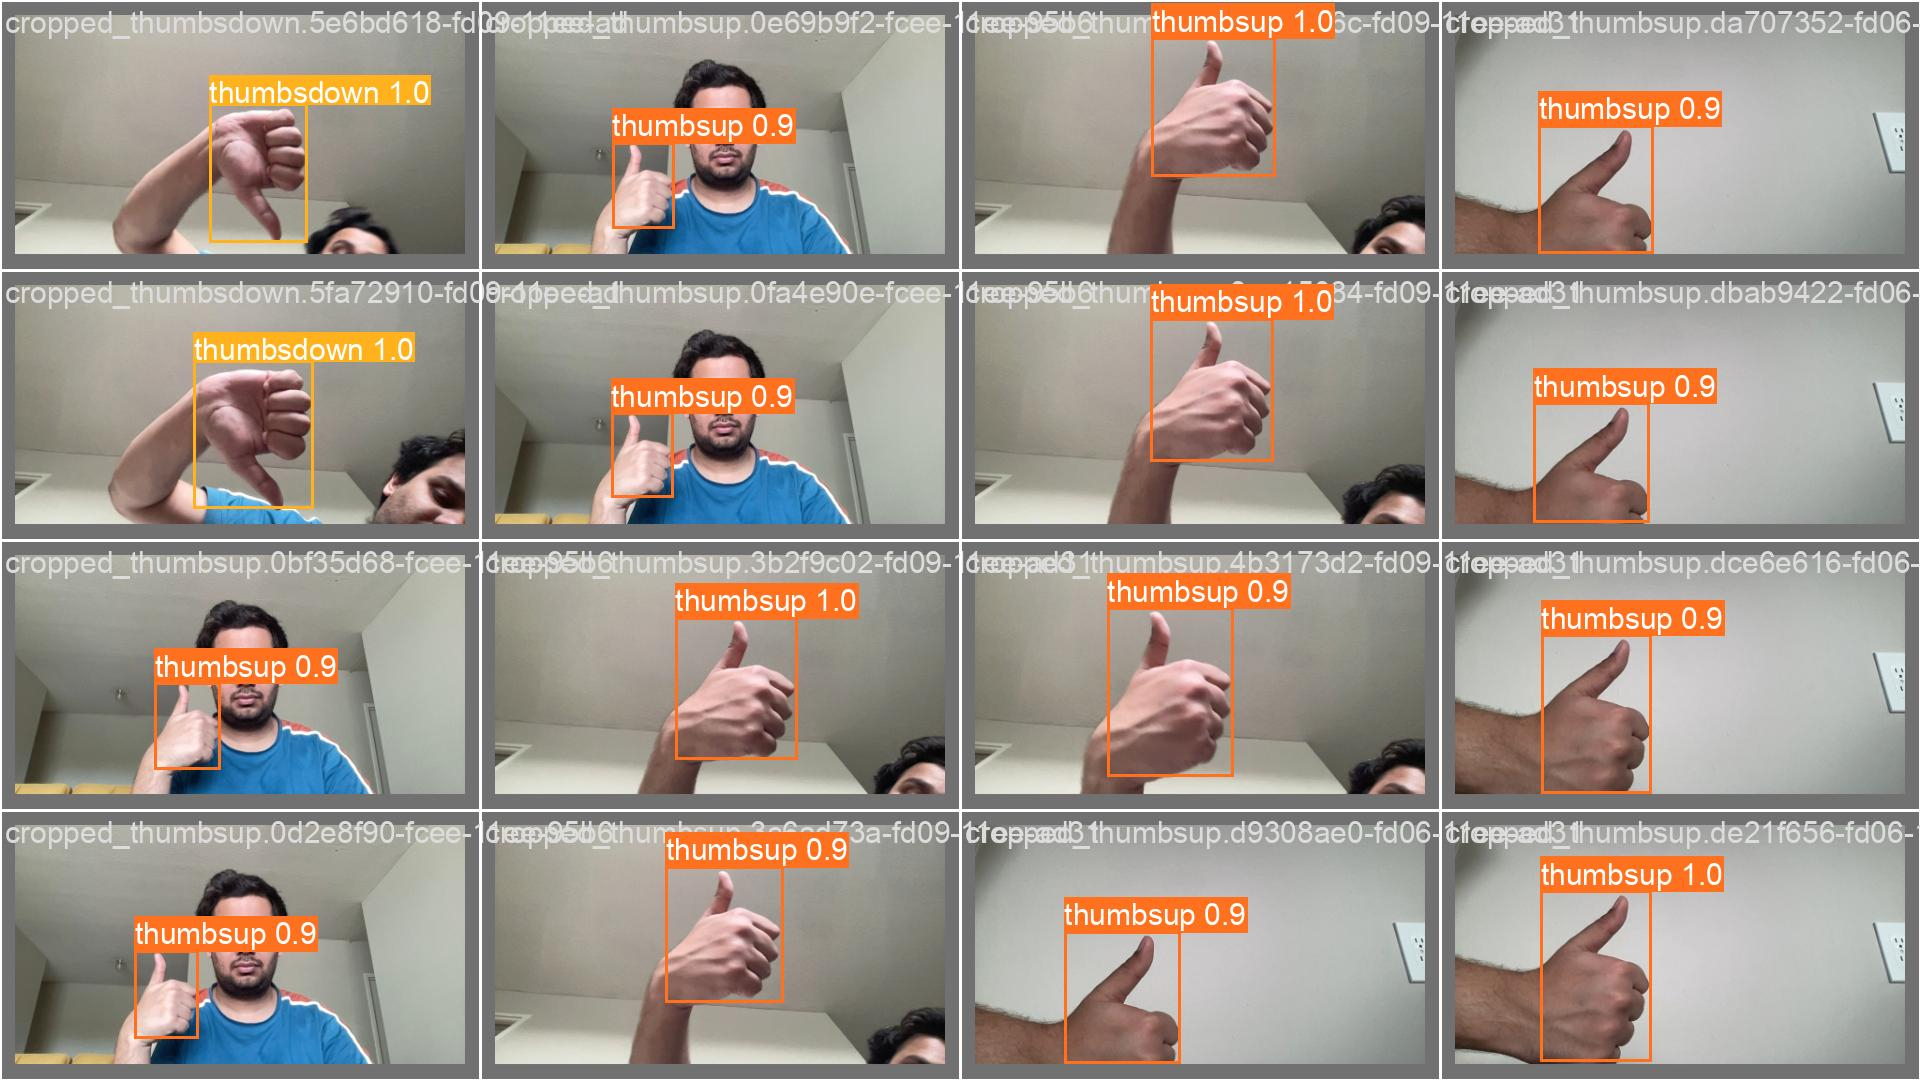

In [22]:

Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_pred.jpg', width=900)

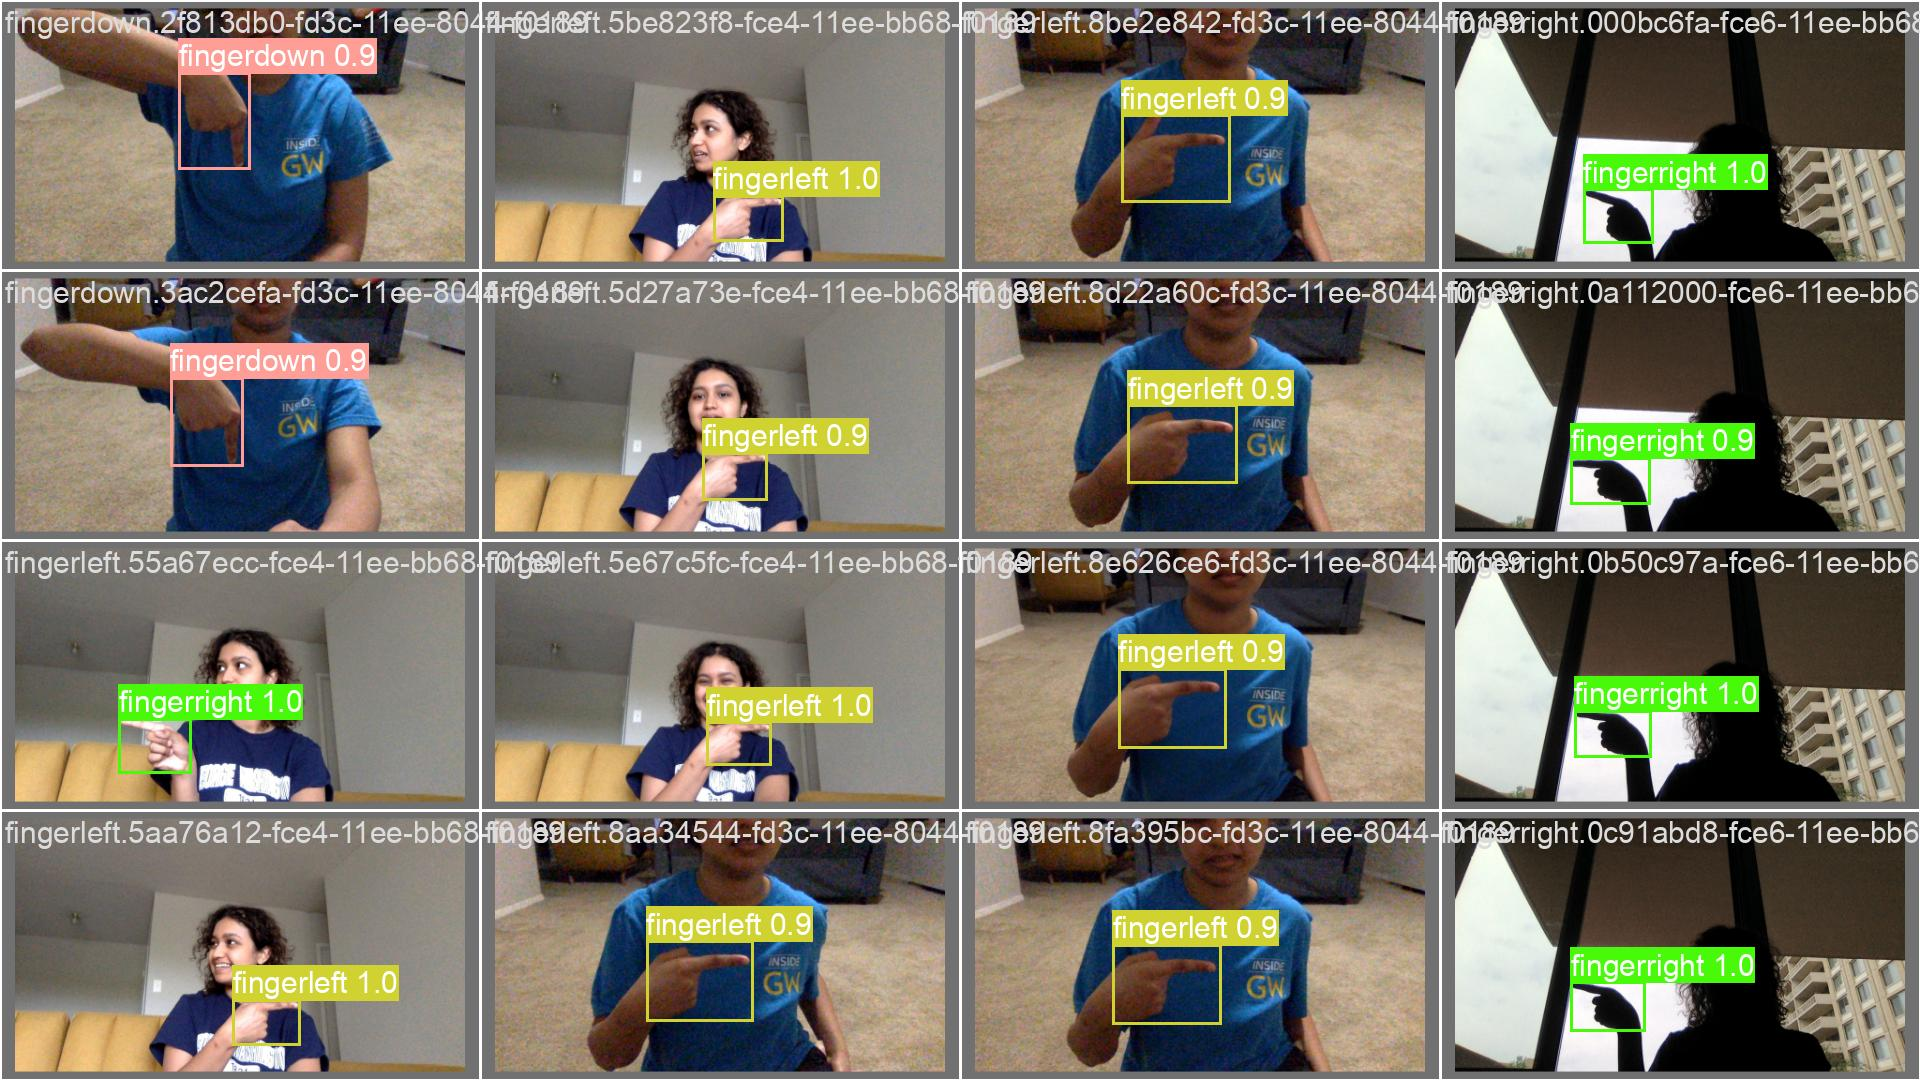

In [21]:

Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch1_pred.jpg', width=900)

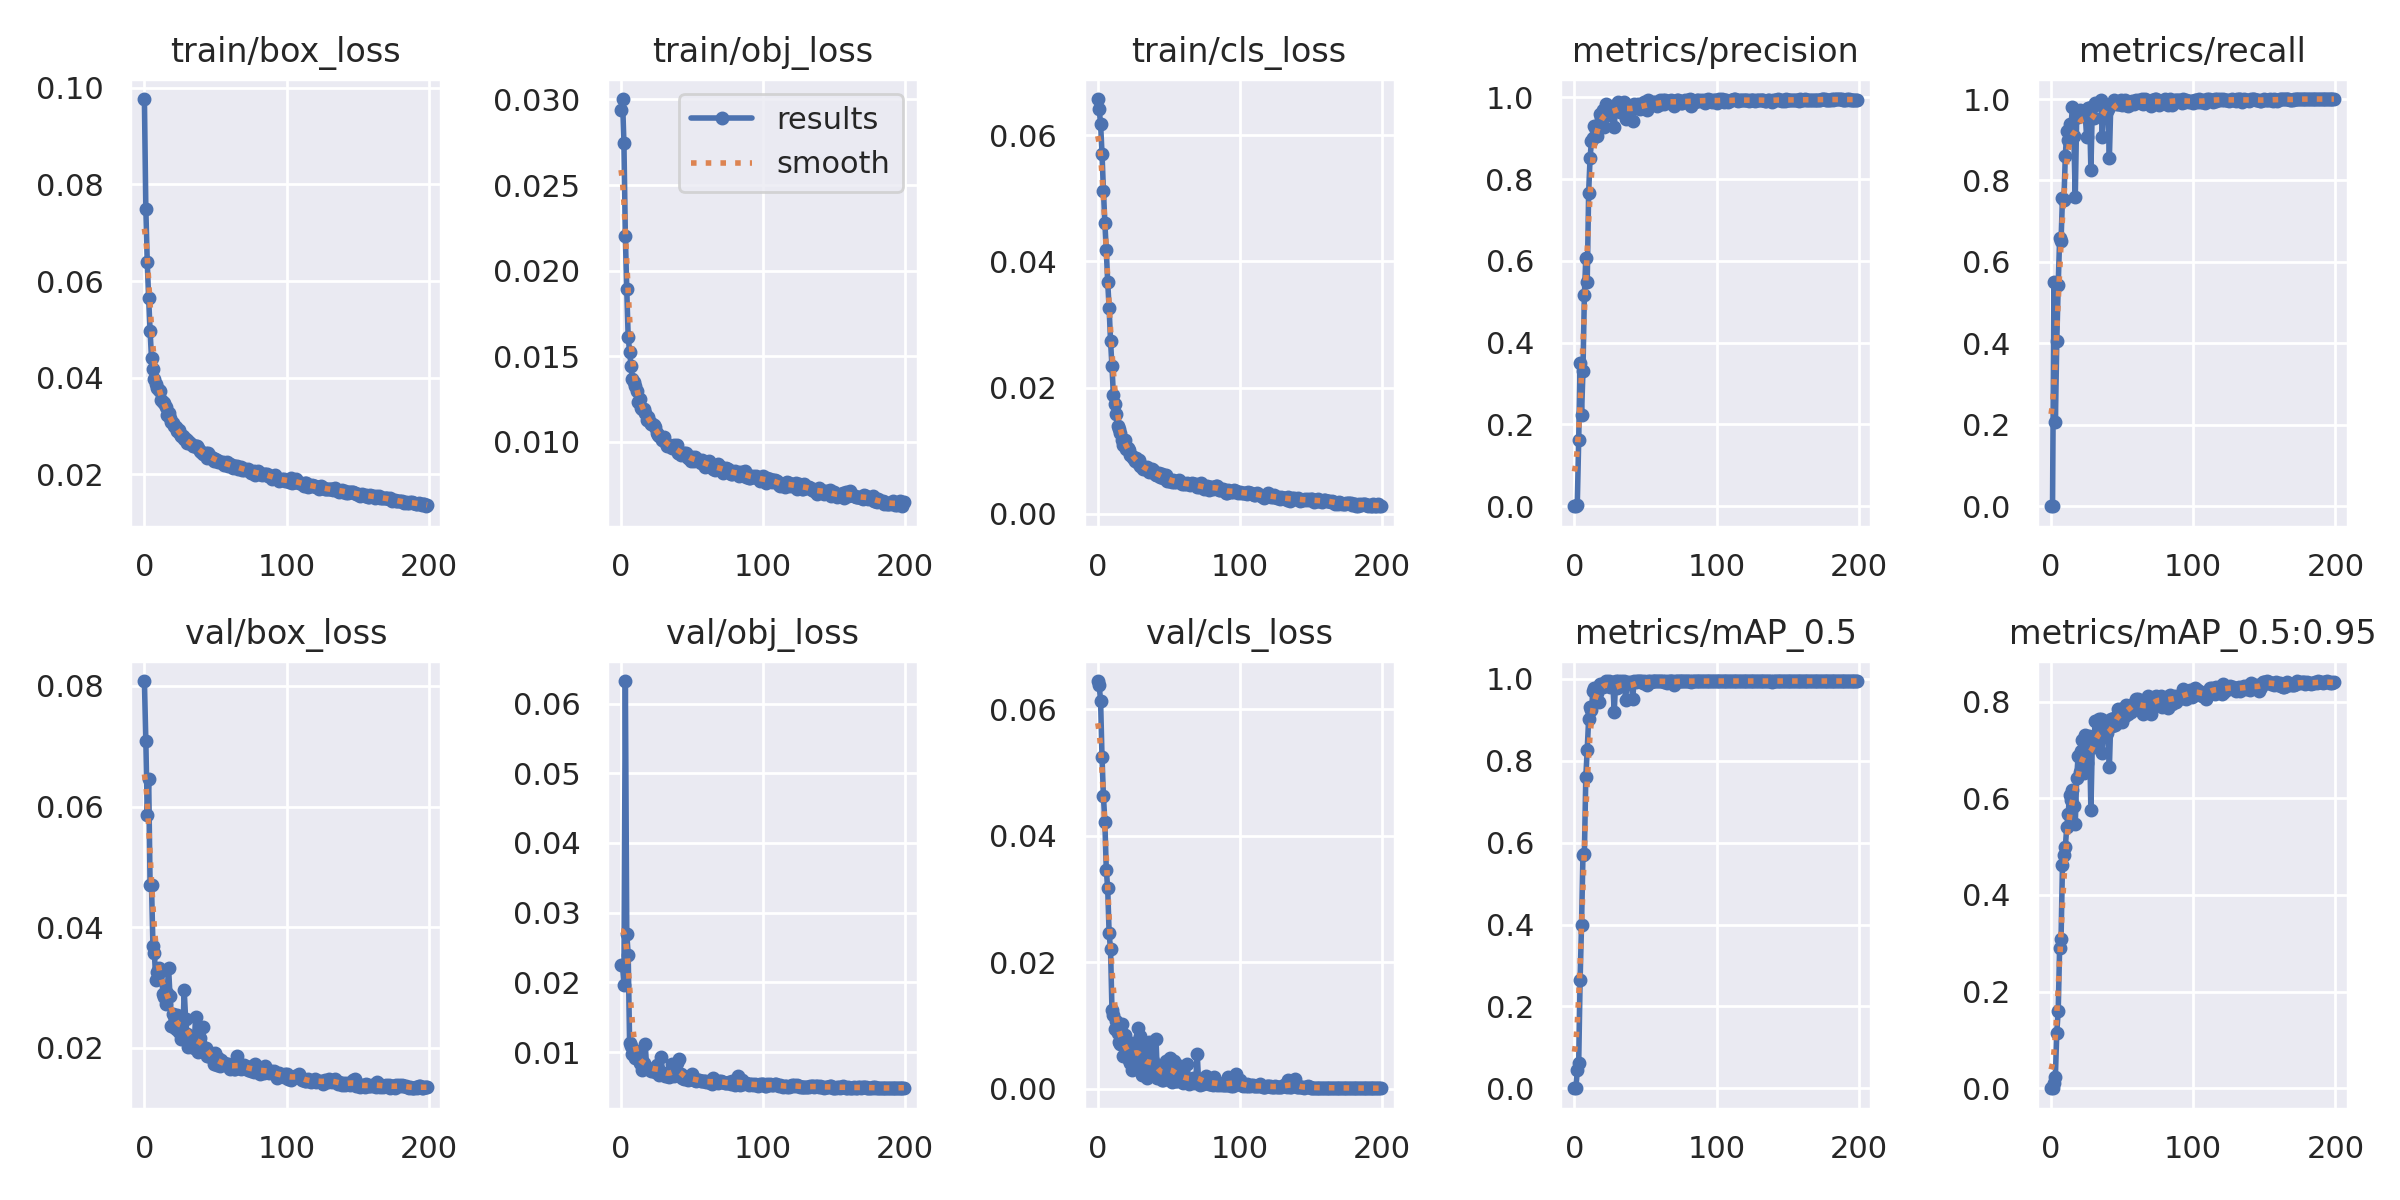

In [31]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)

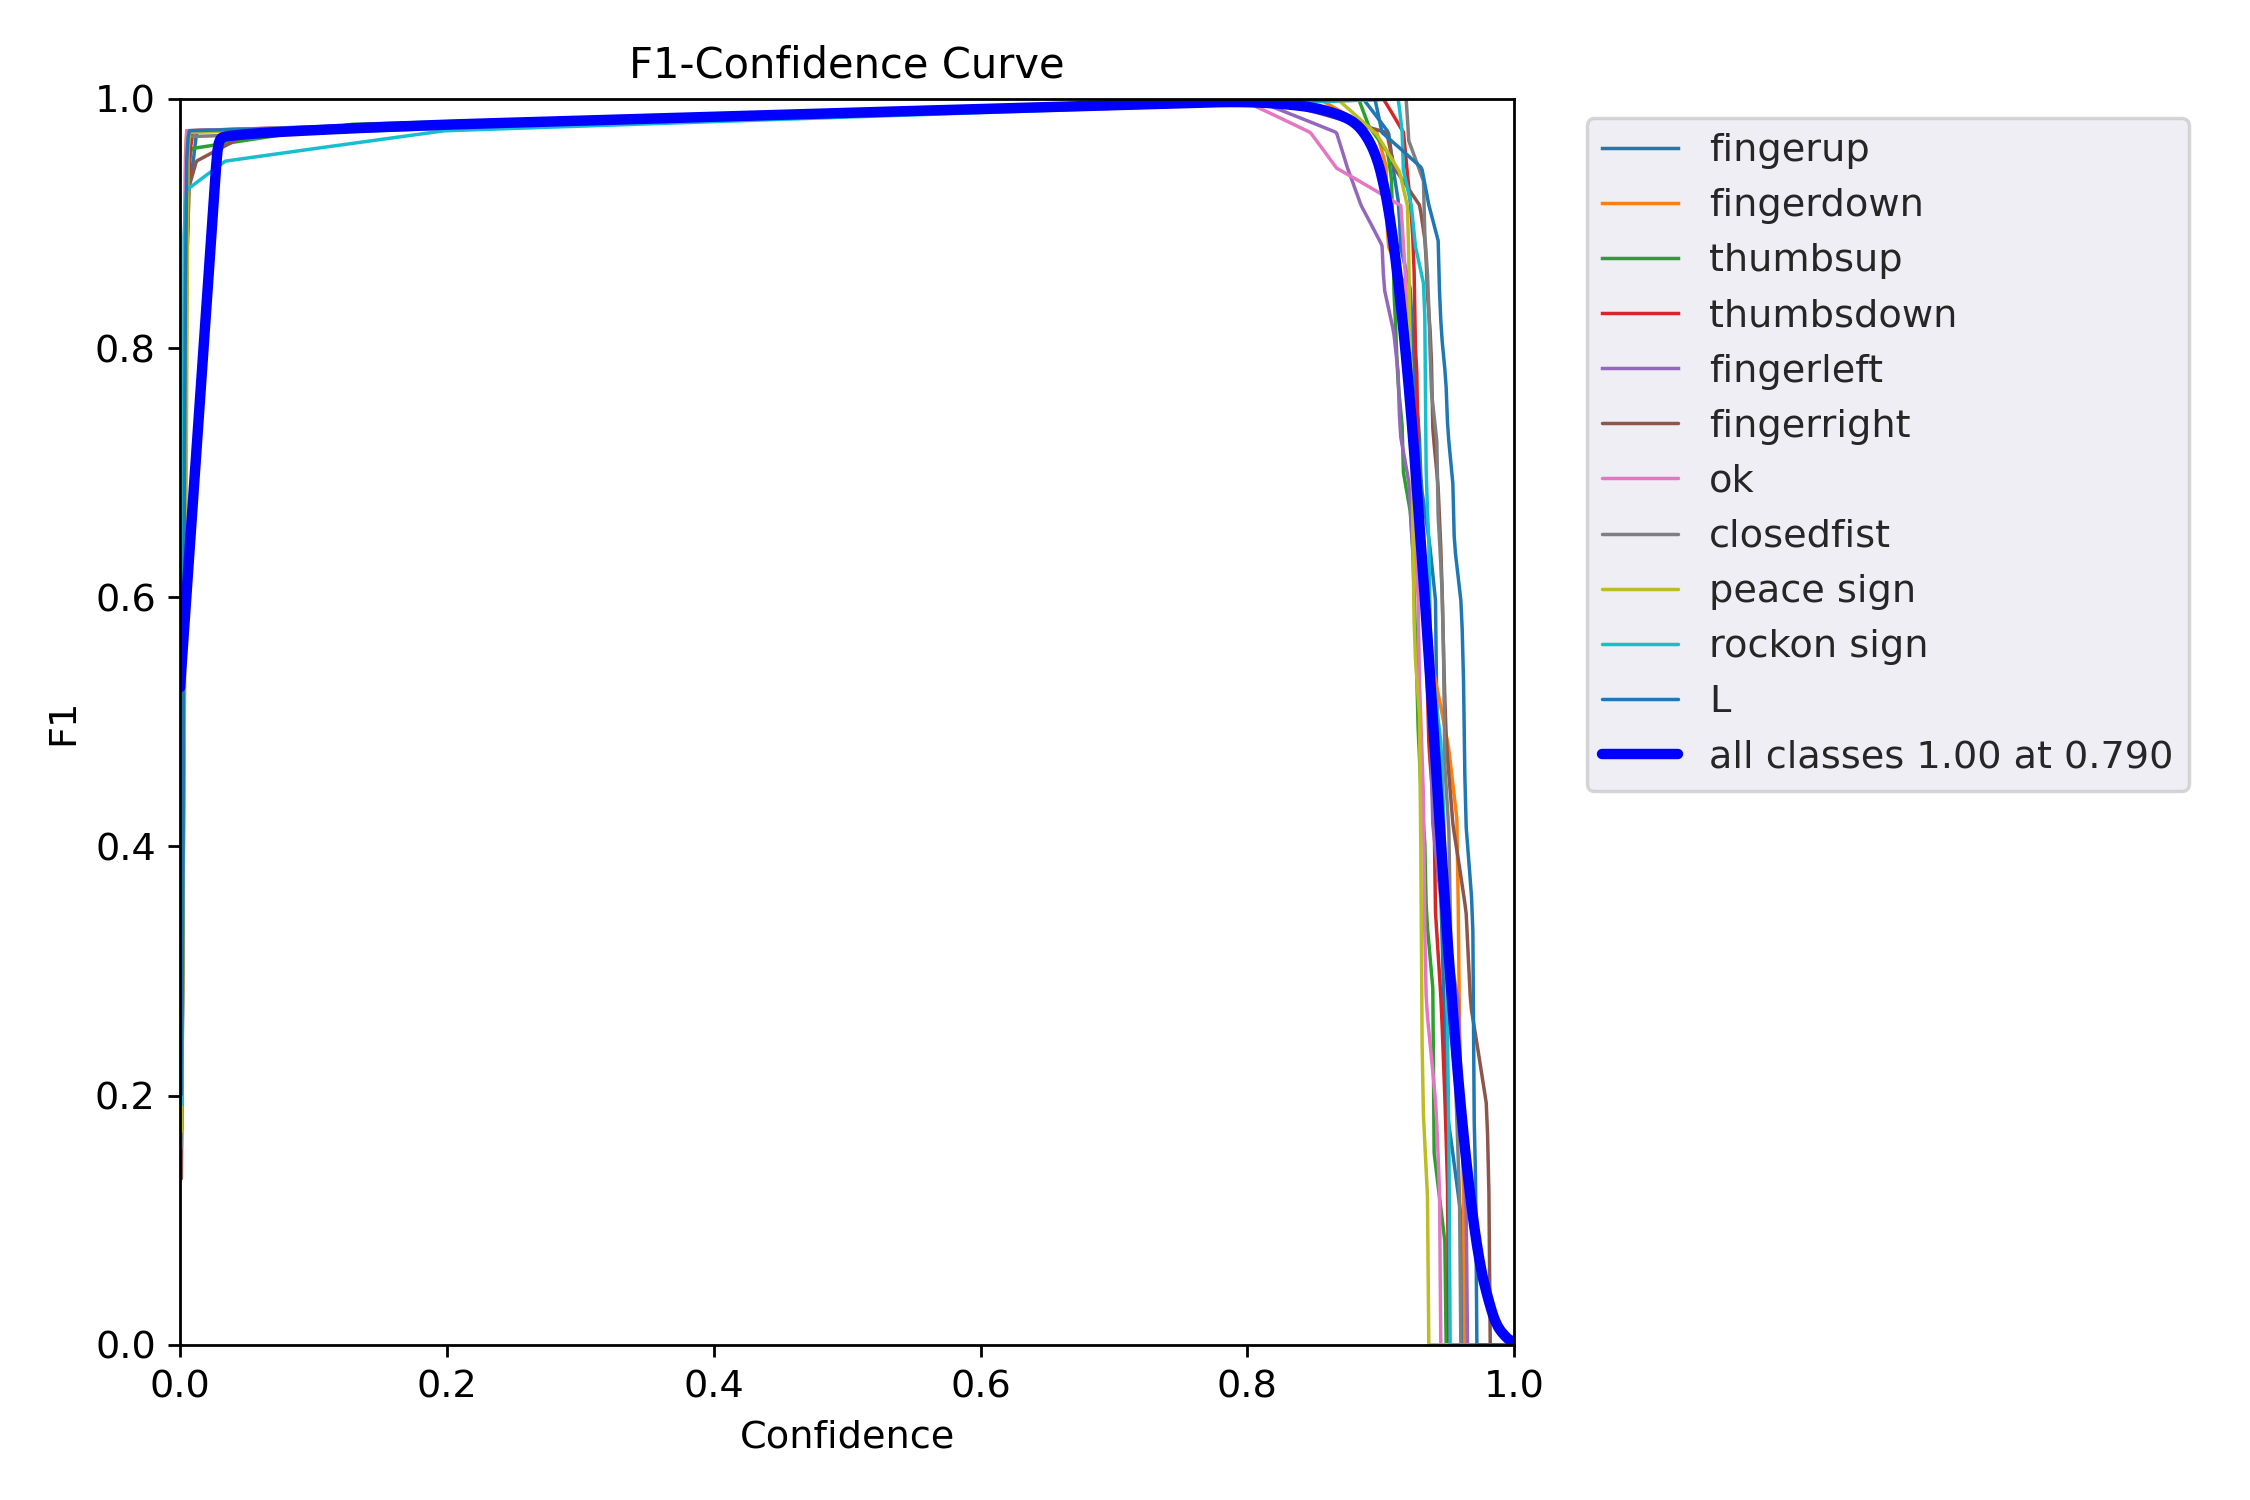

In [32]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/F1_curve.png', width=1000)

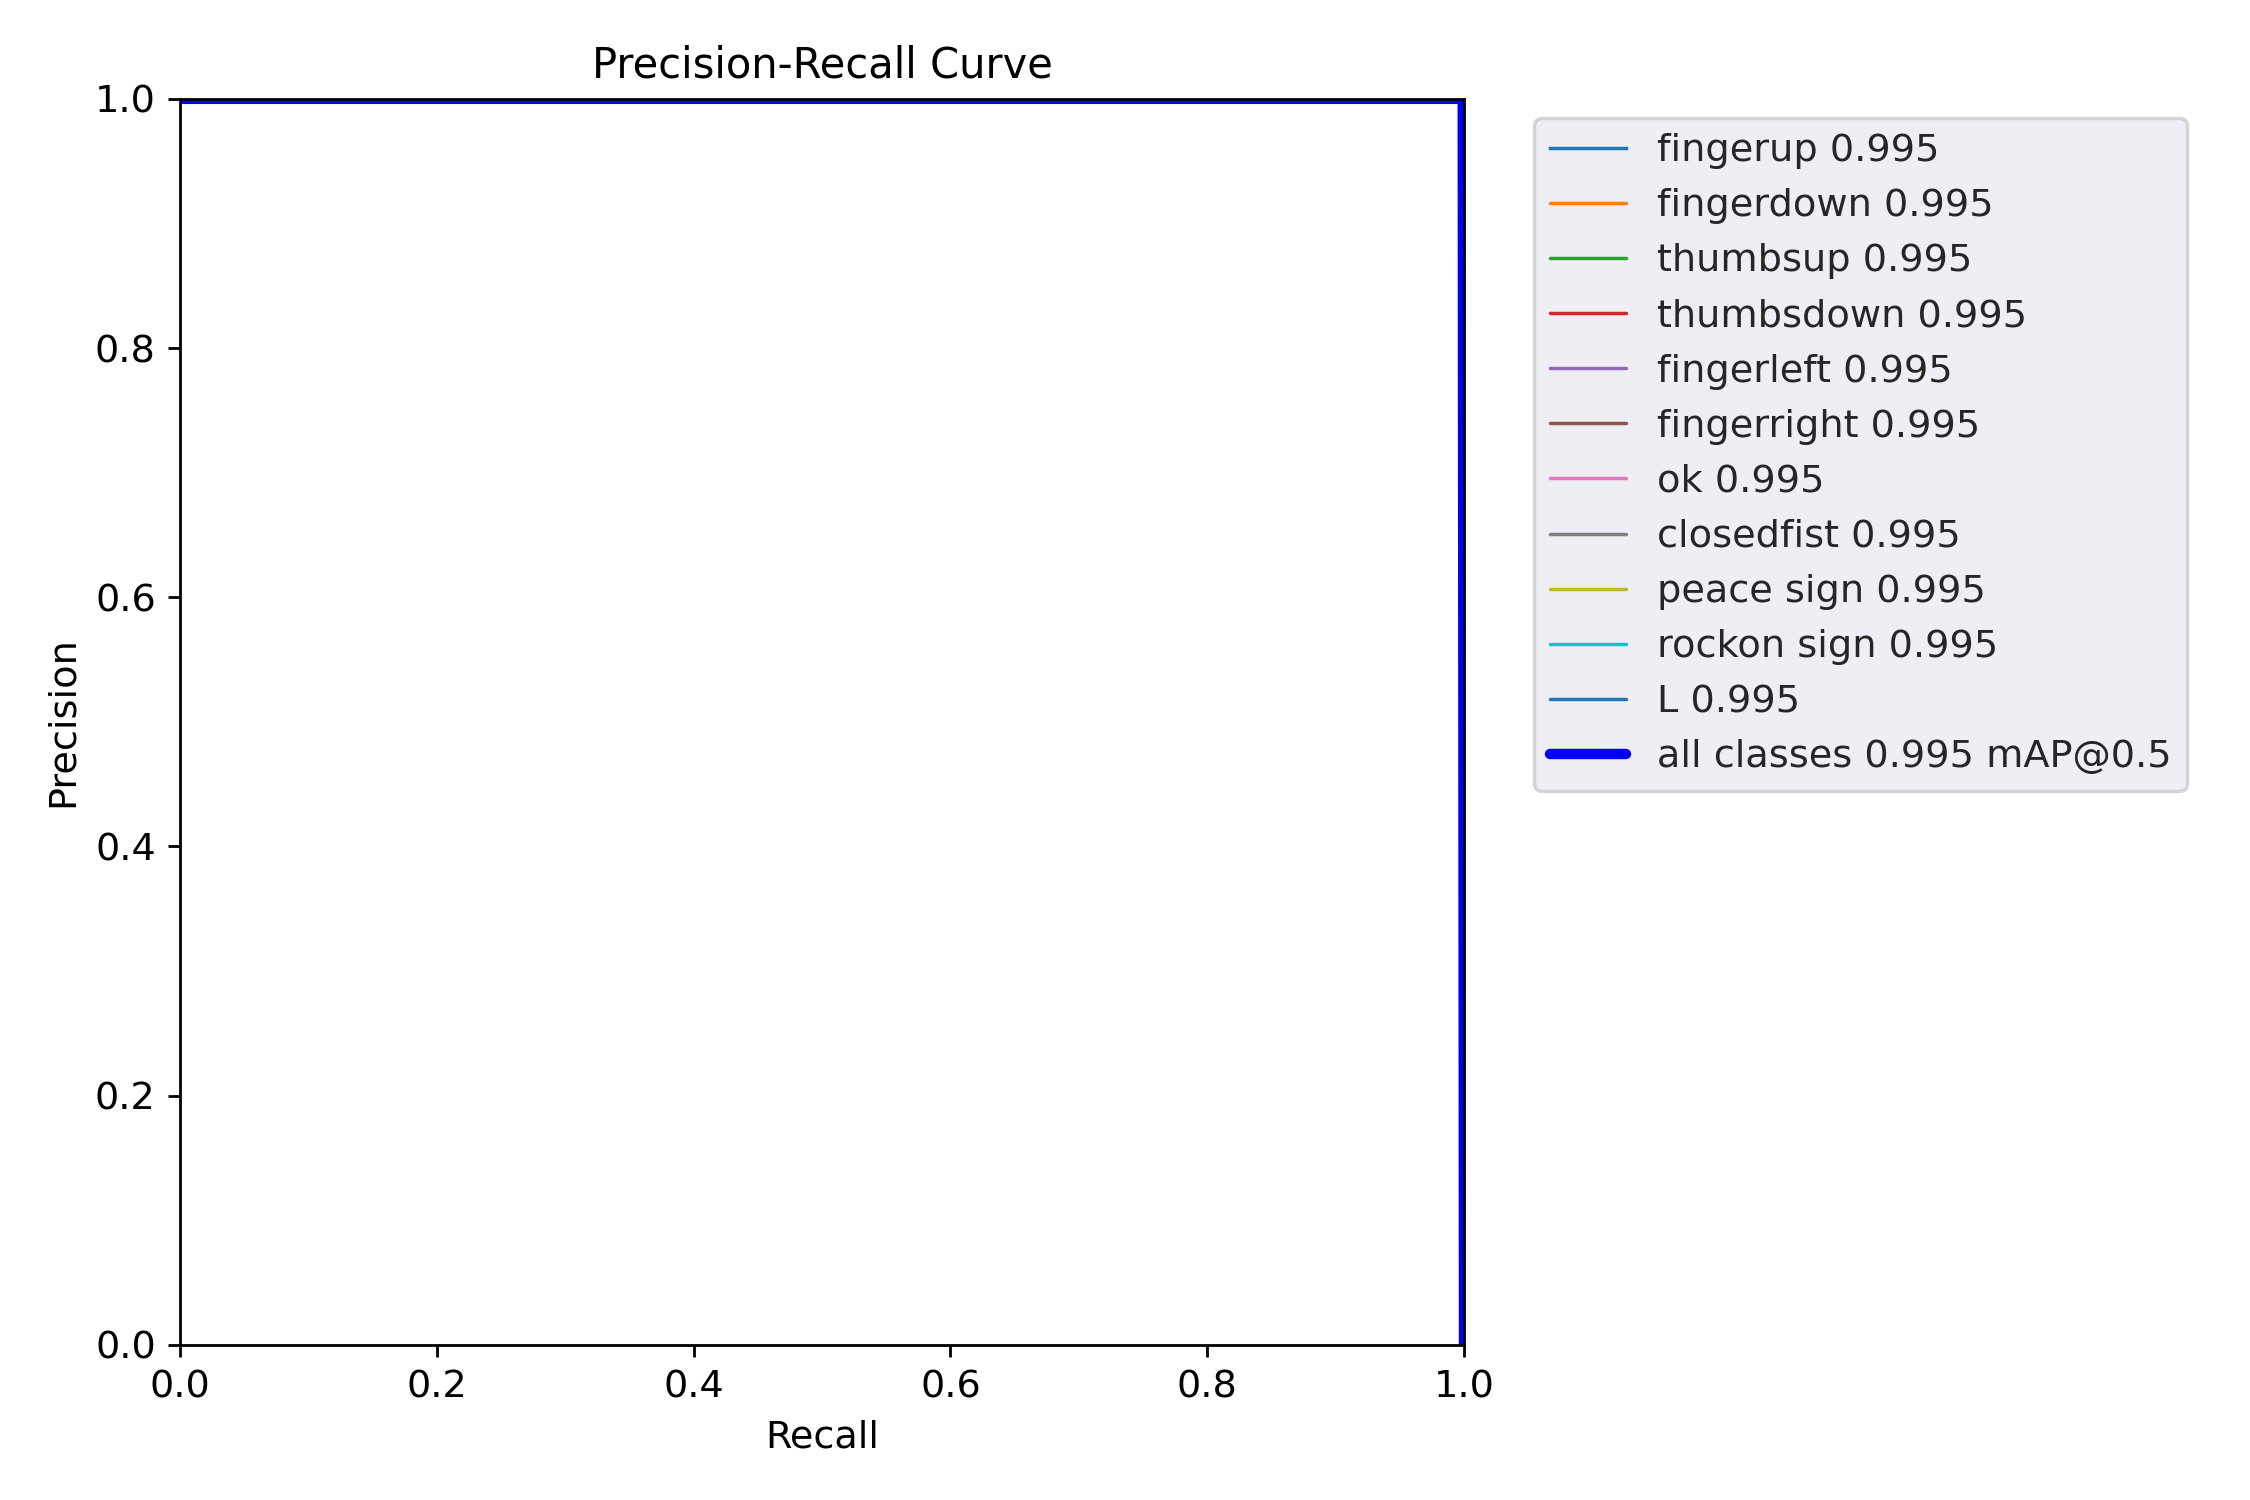

In [33]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/PR_curve.png', width=1000)

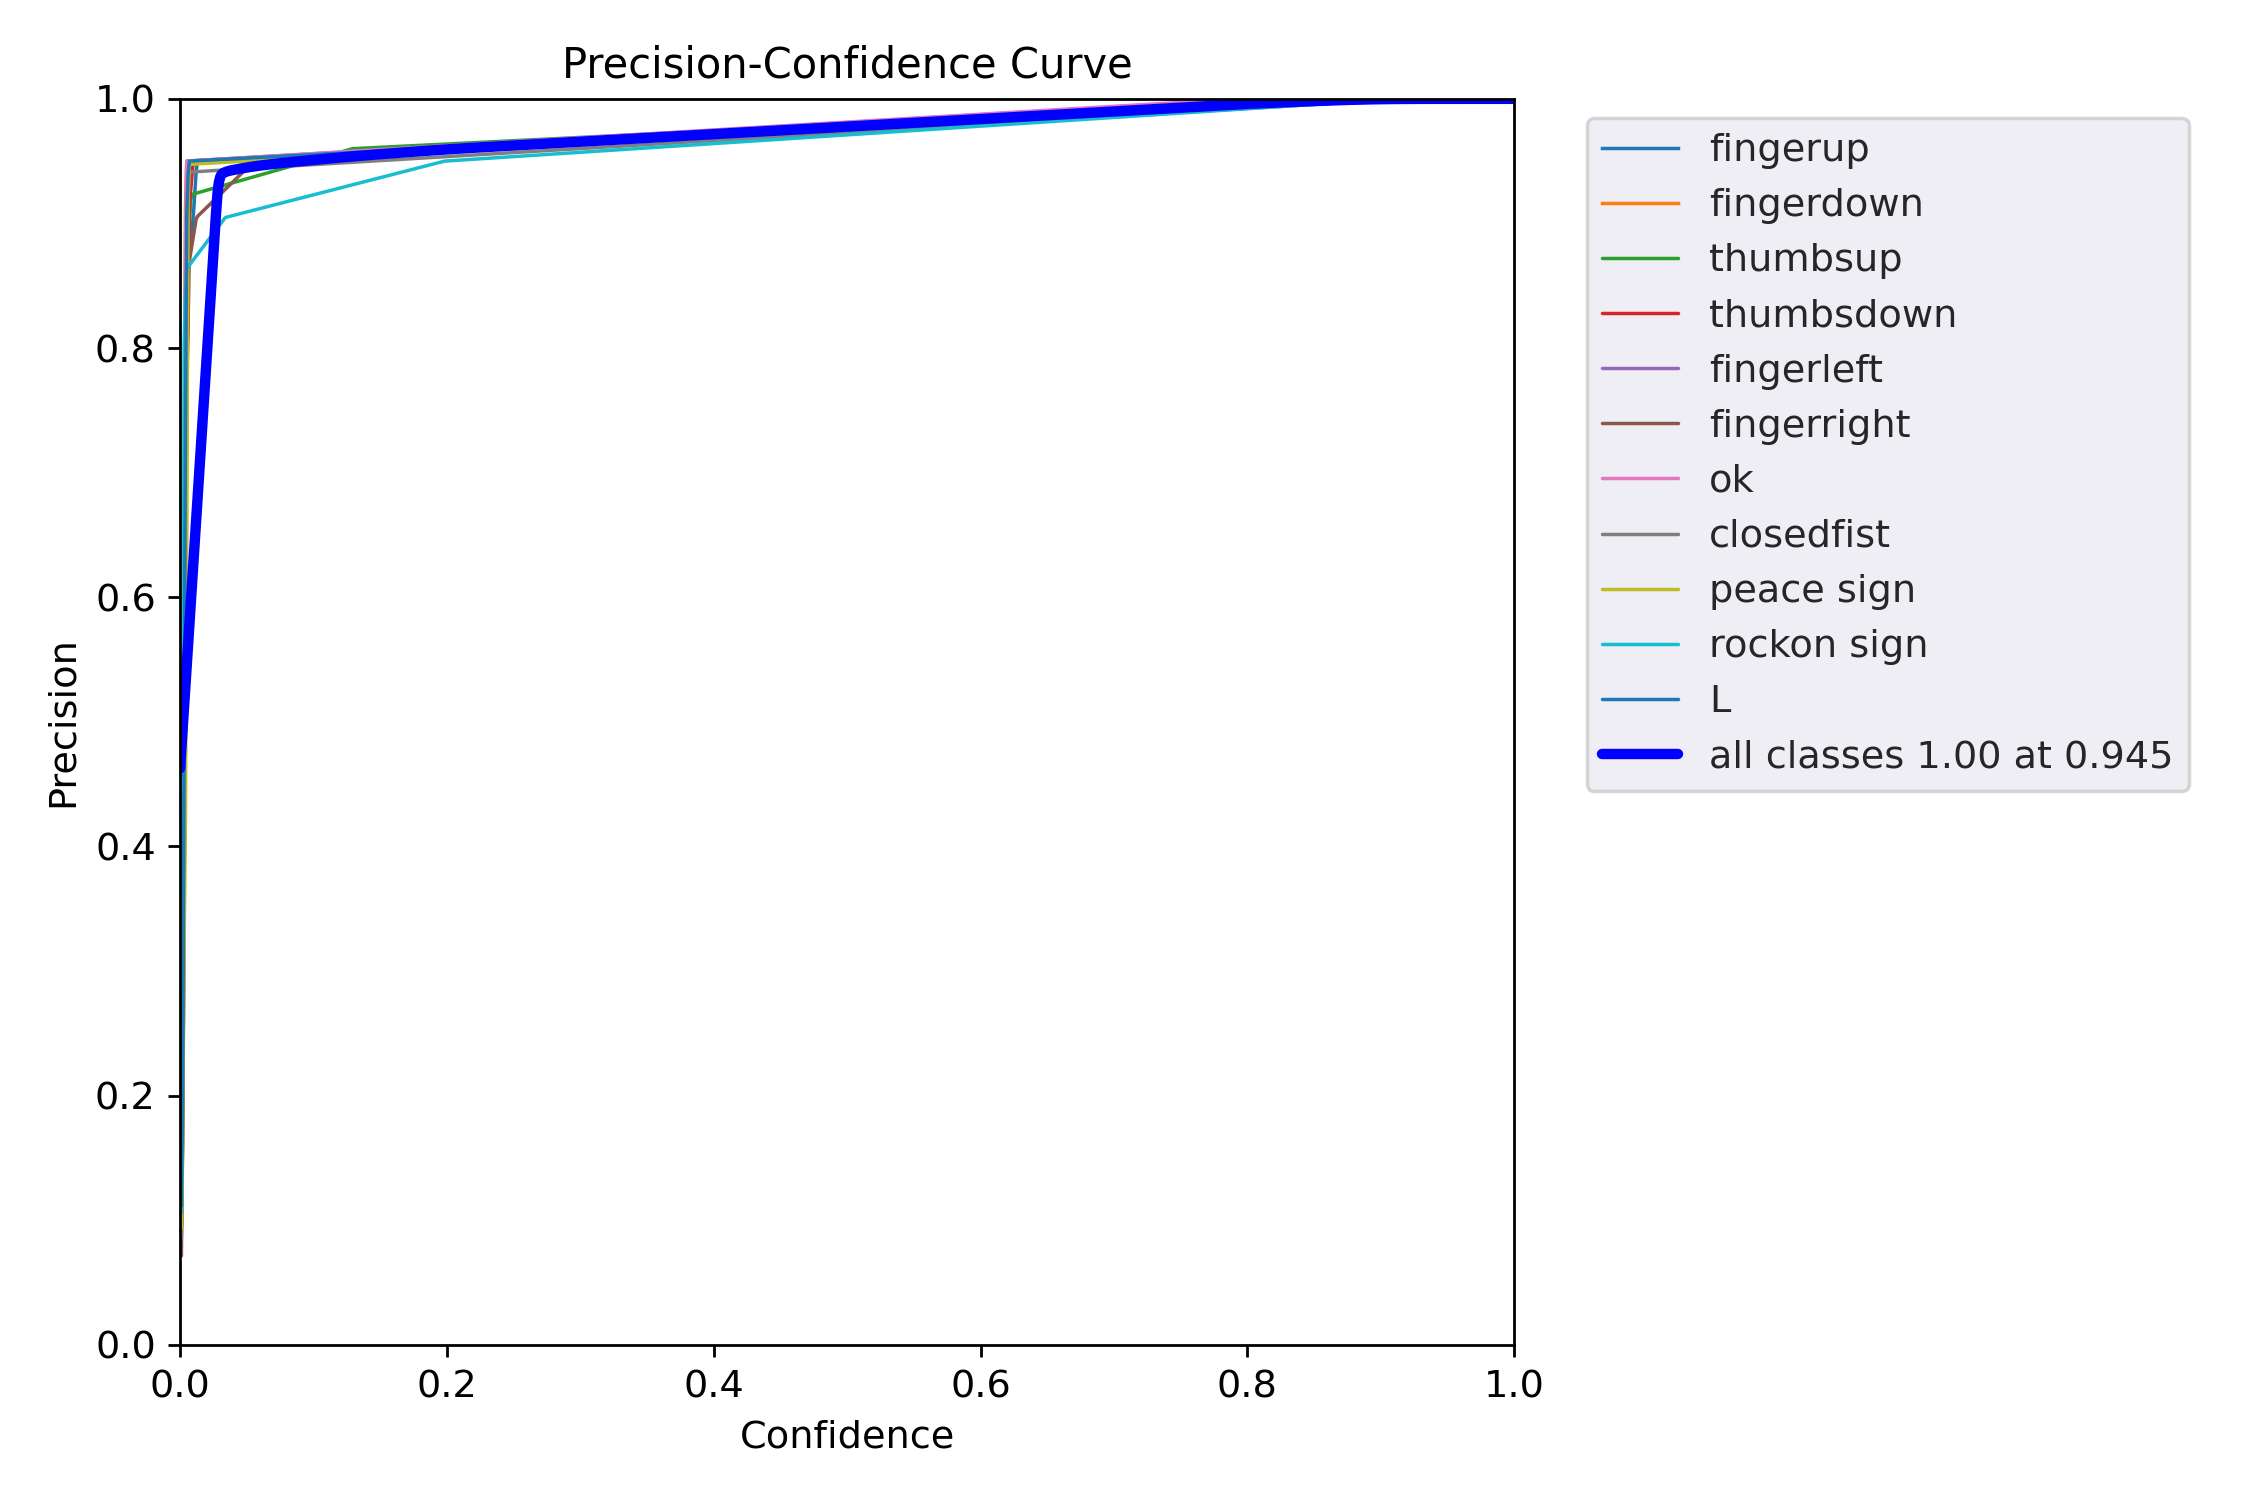

In [34]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/P_curve.png', width=1000)

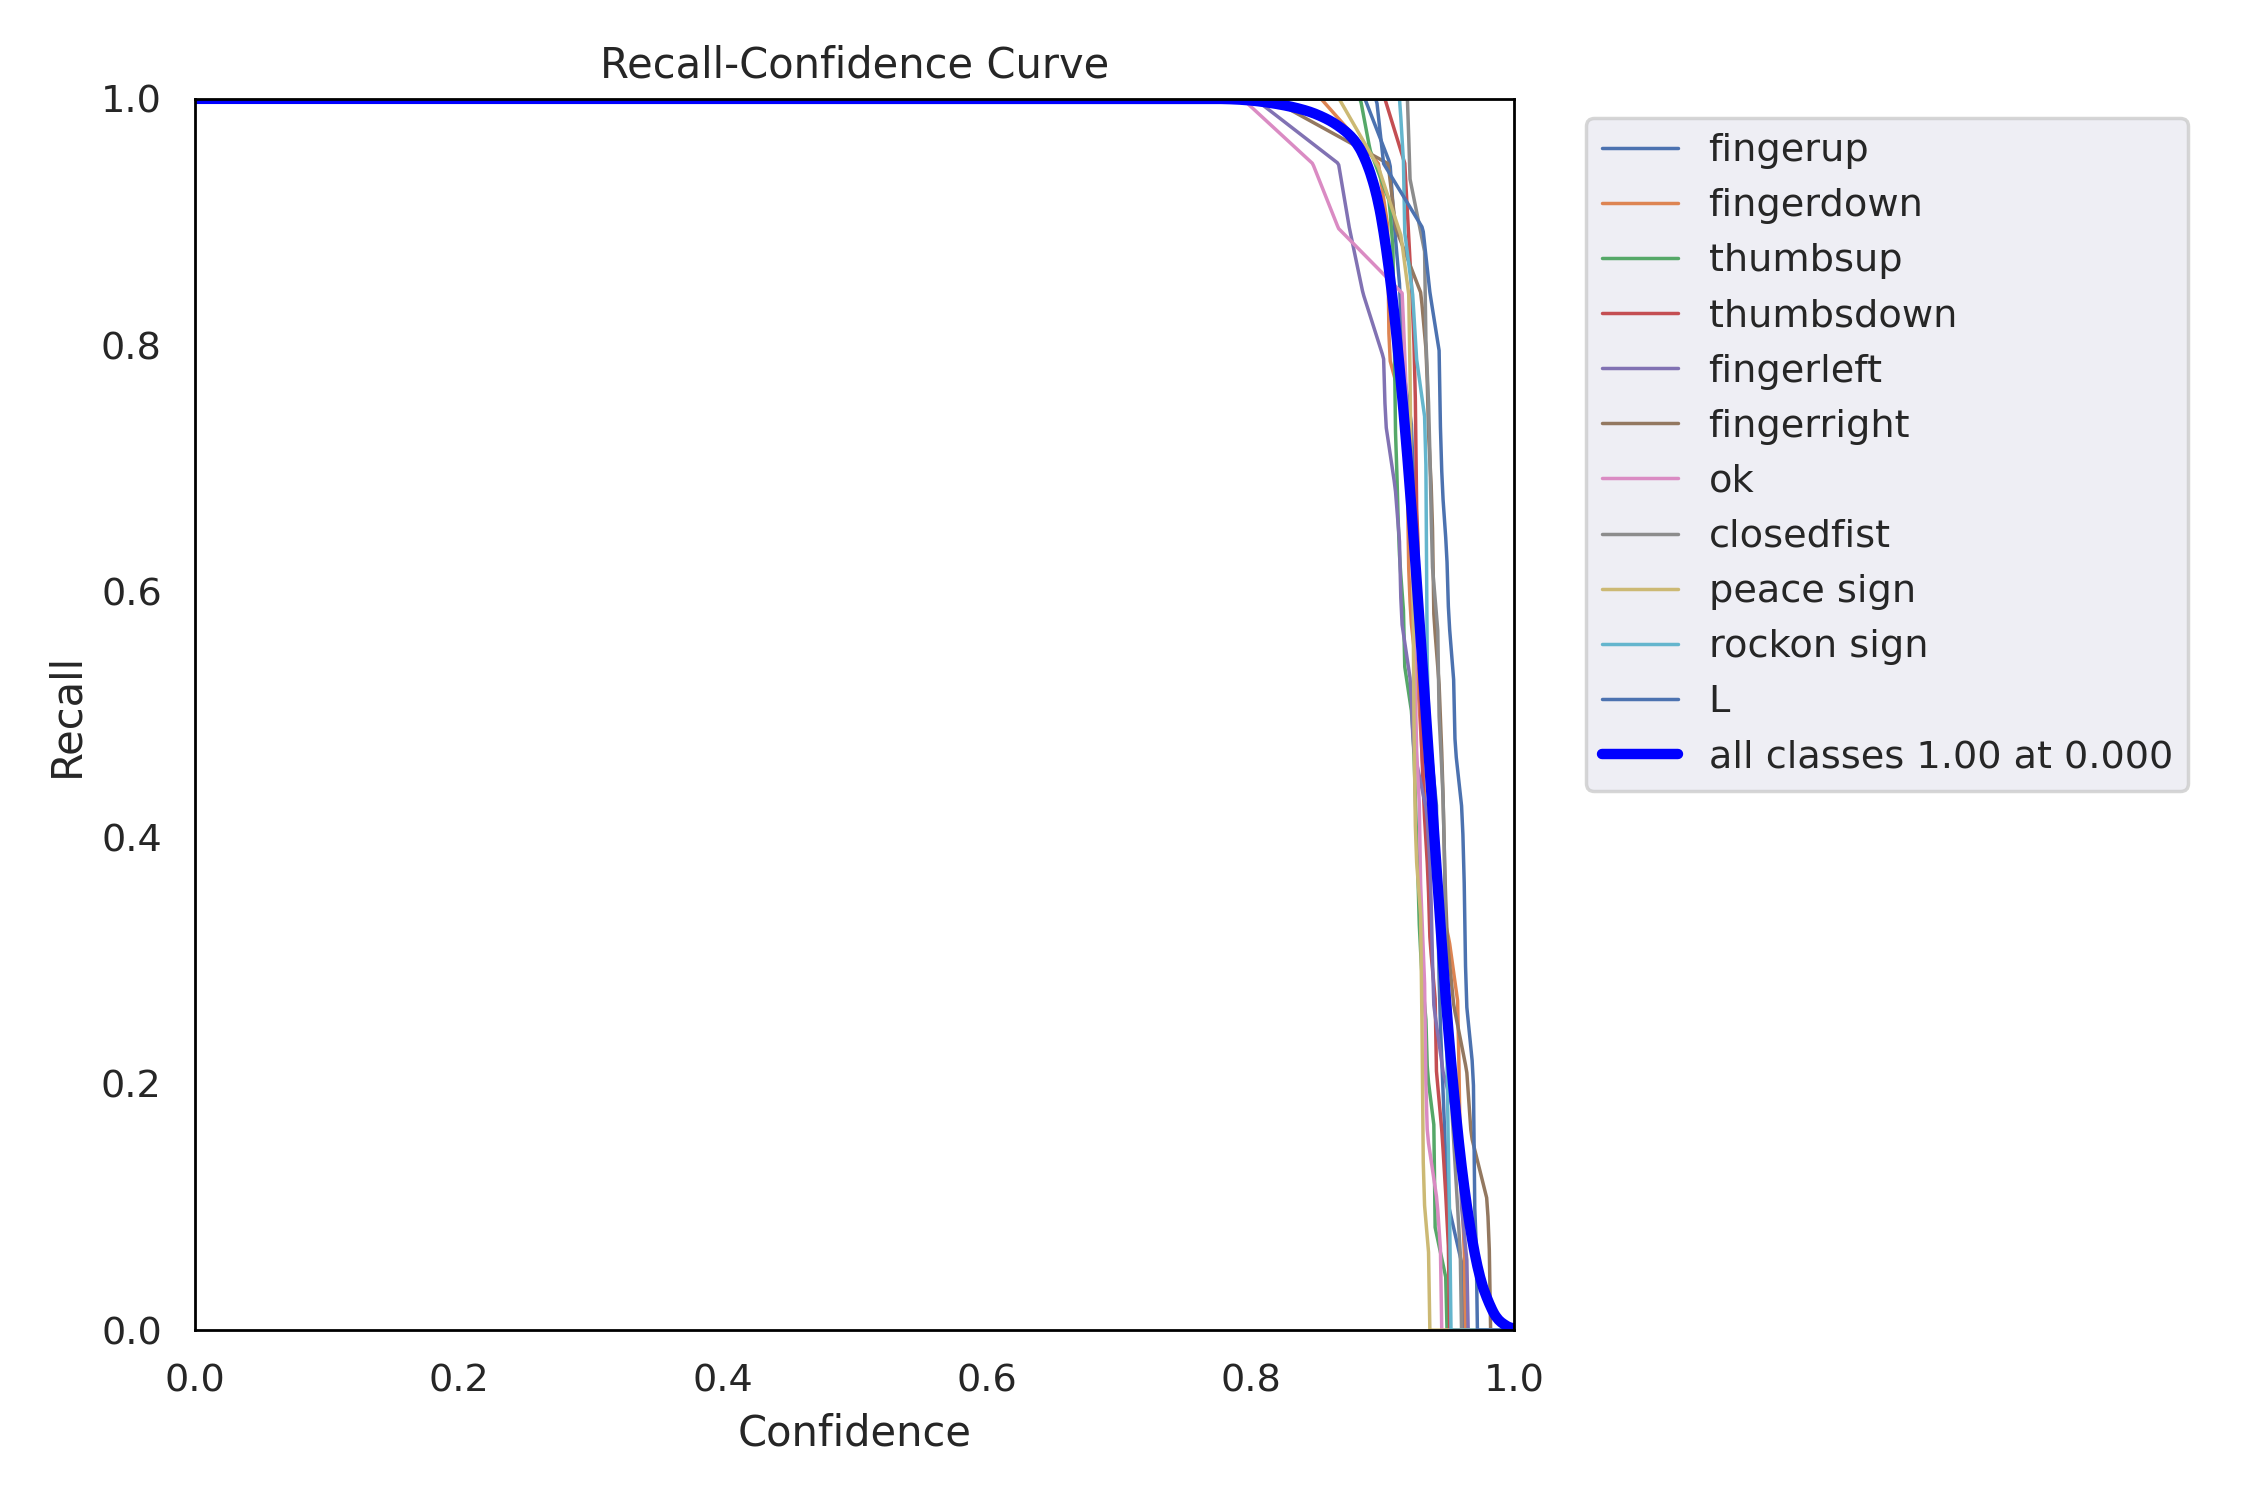

In [35]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/R_curve.png', width=1000)

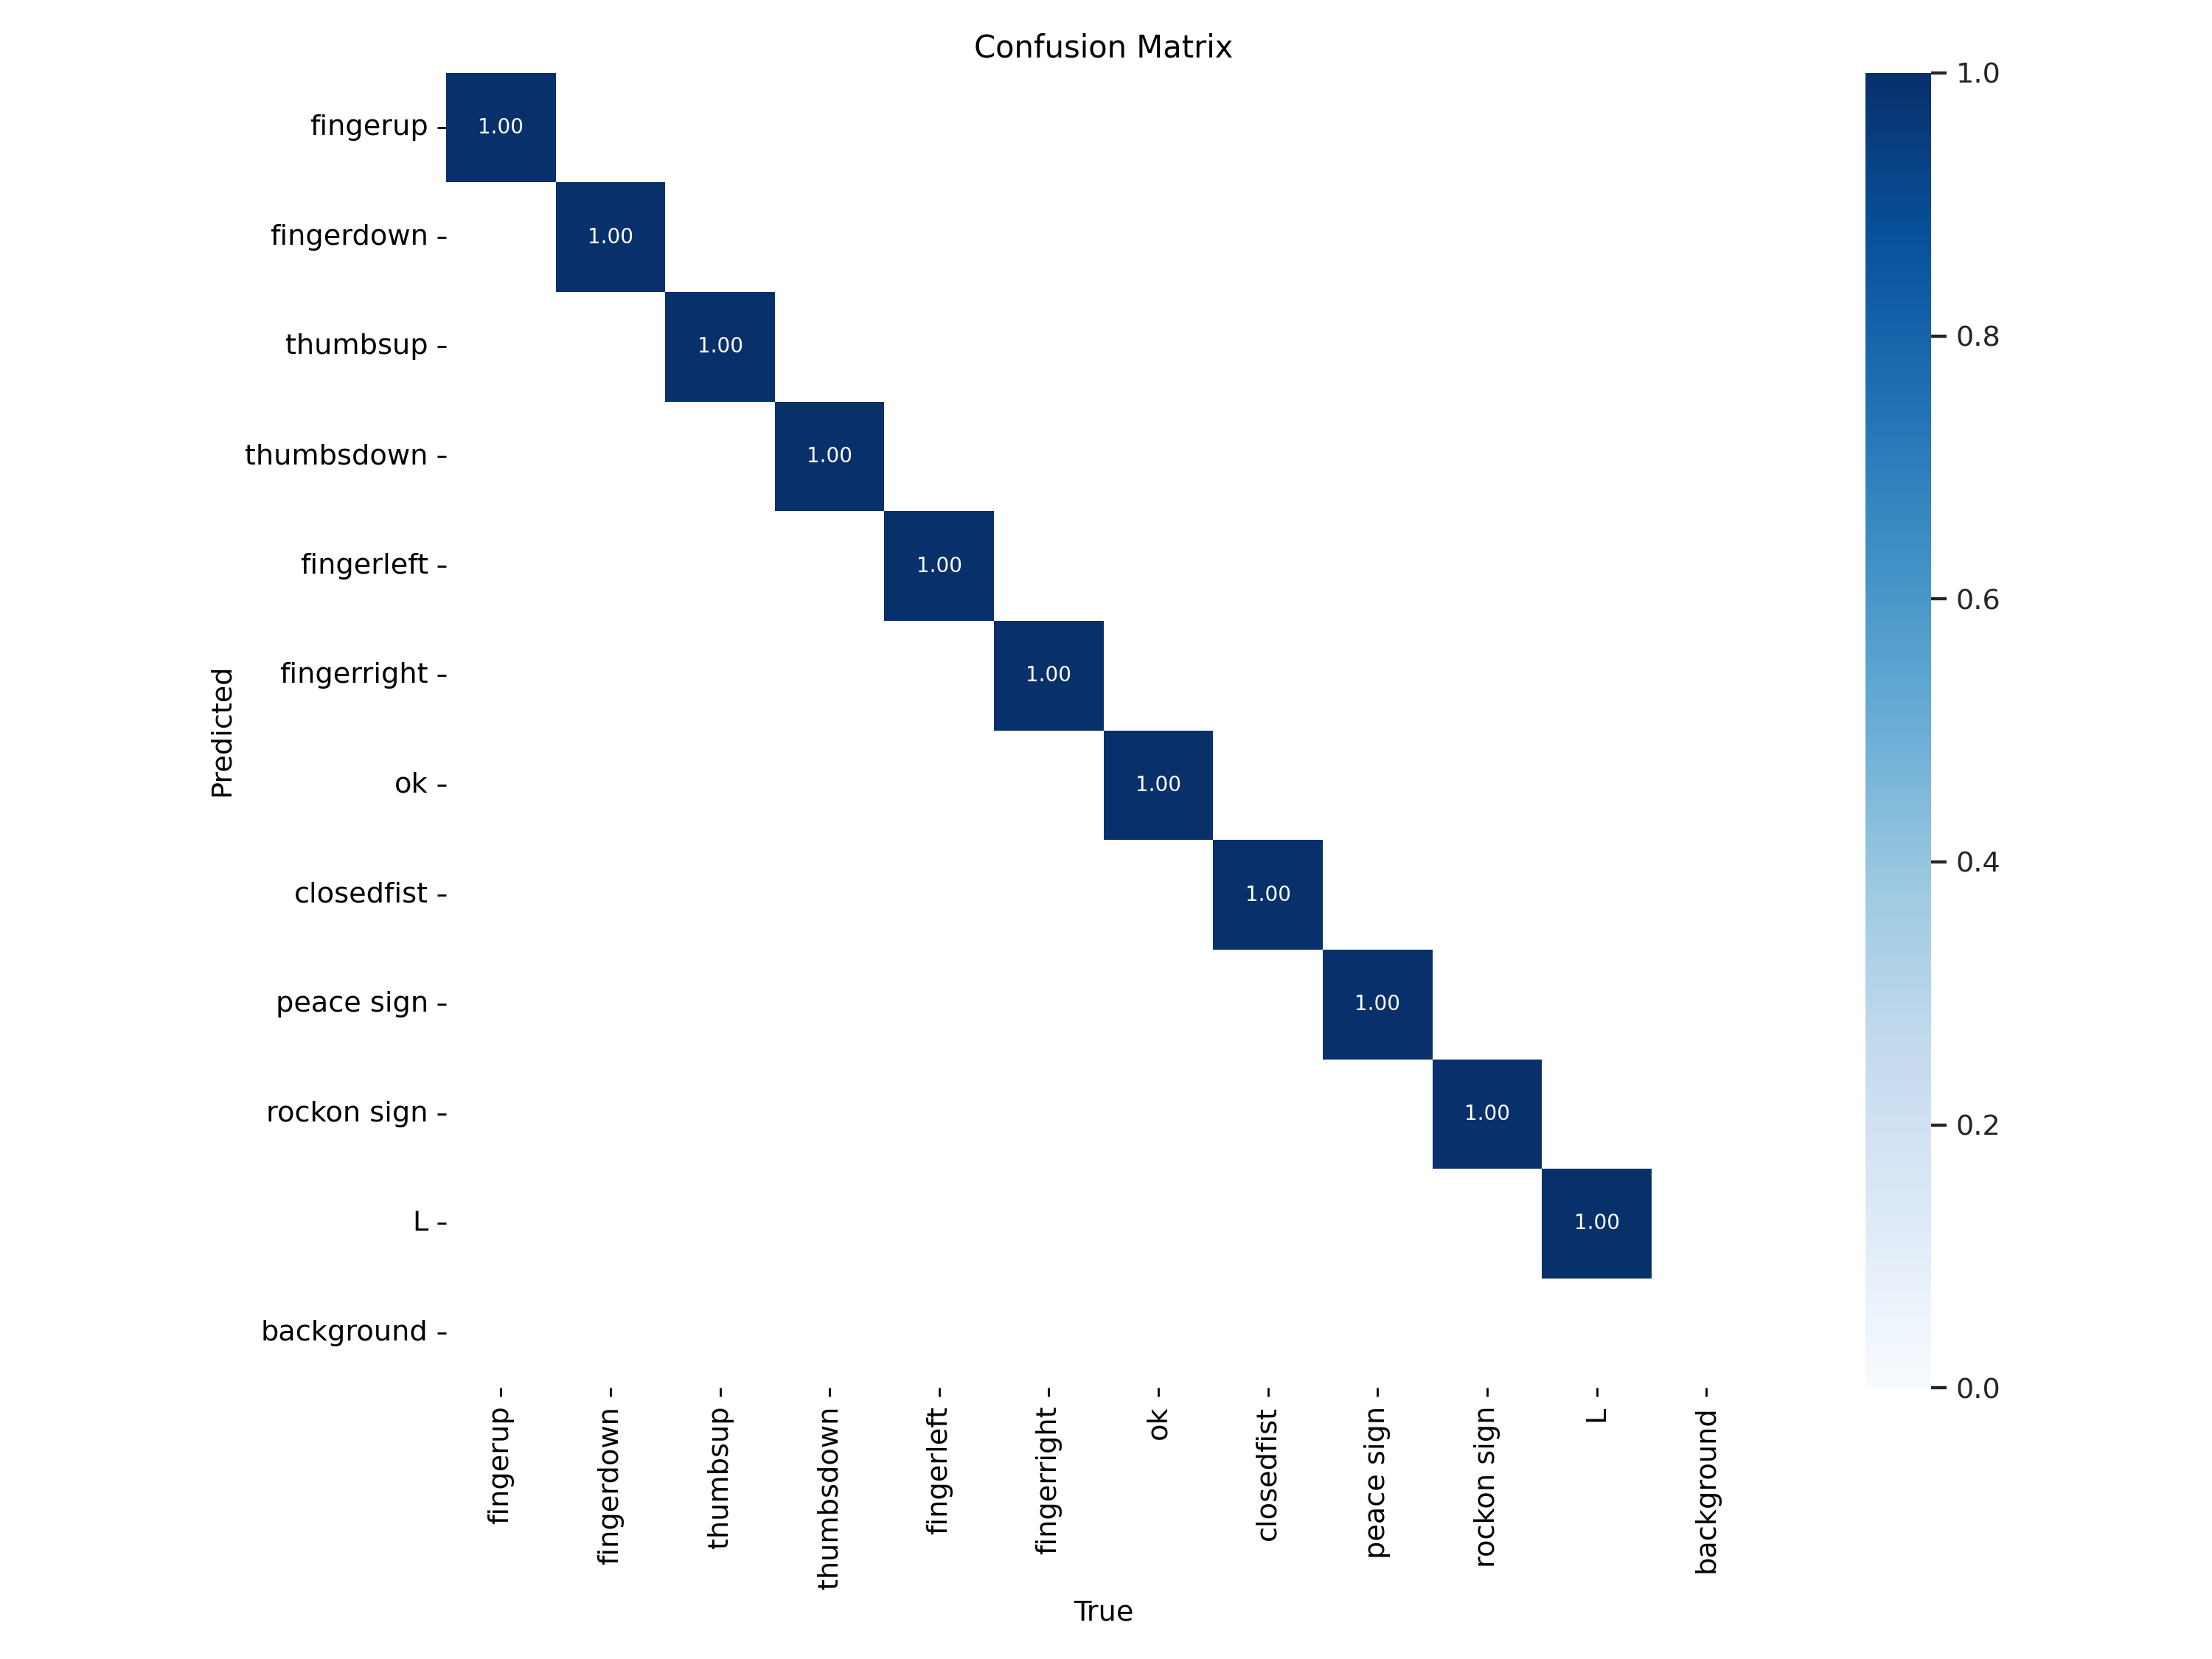

In [36]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/confusion_matrix.png', width=1000)

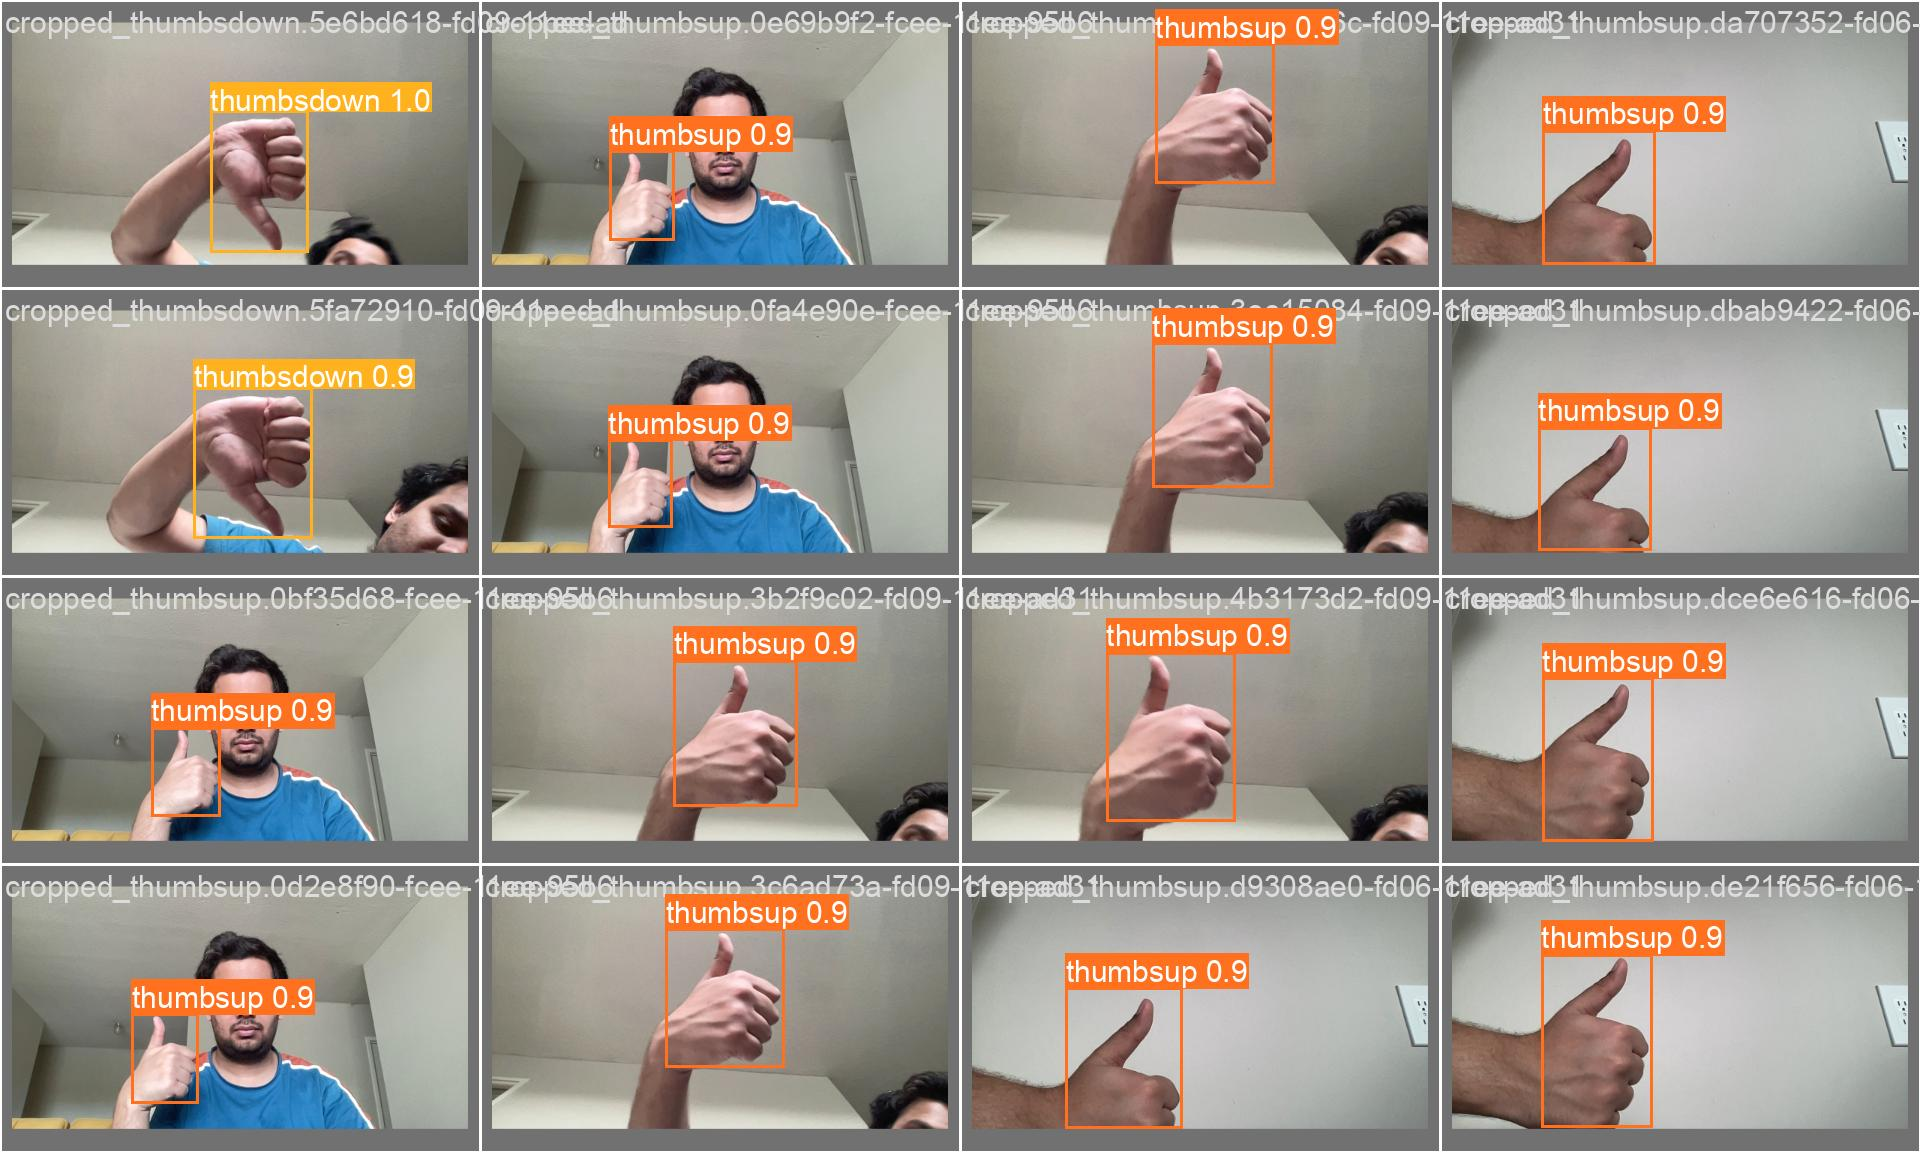

In [37]:

Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch0_pred.jpg', width=900)

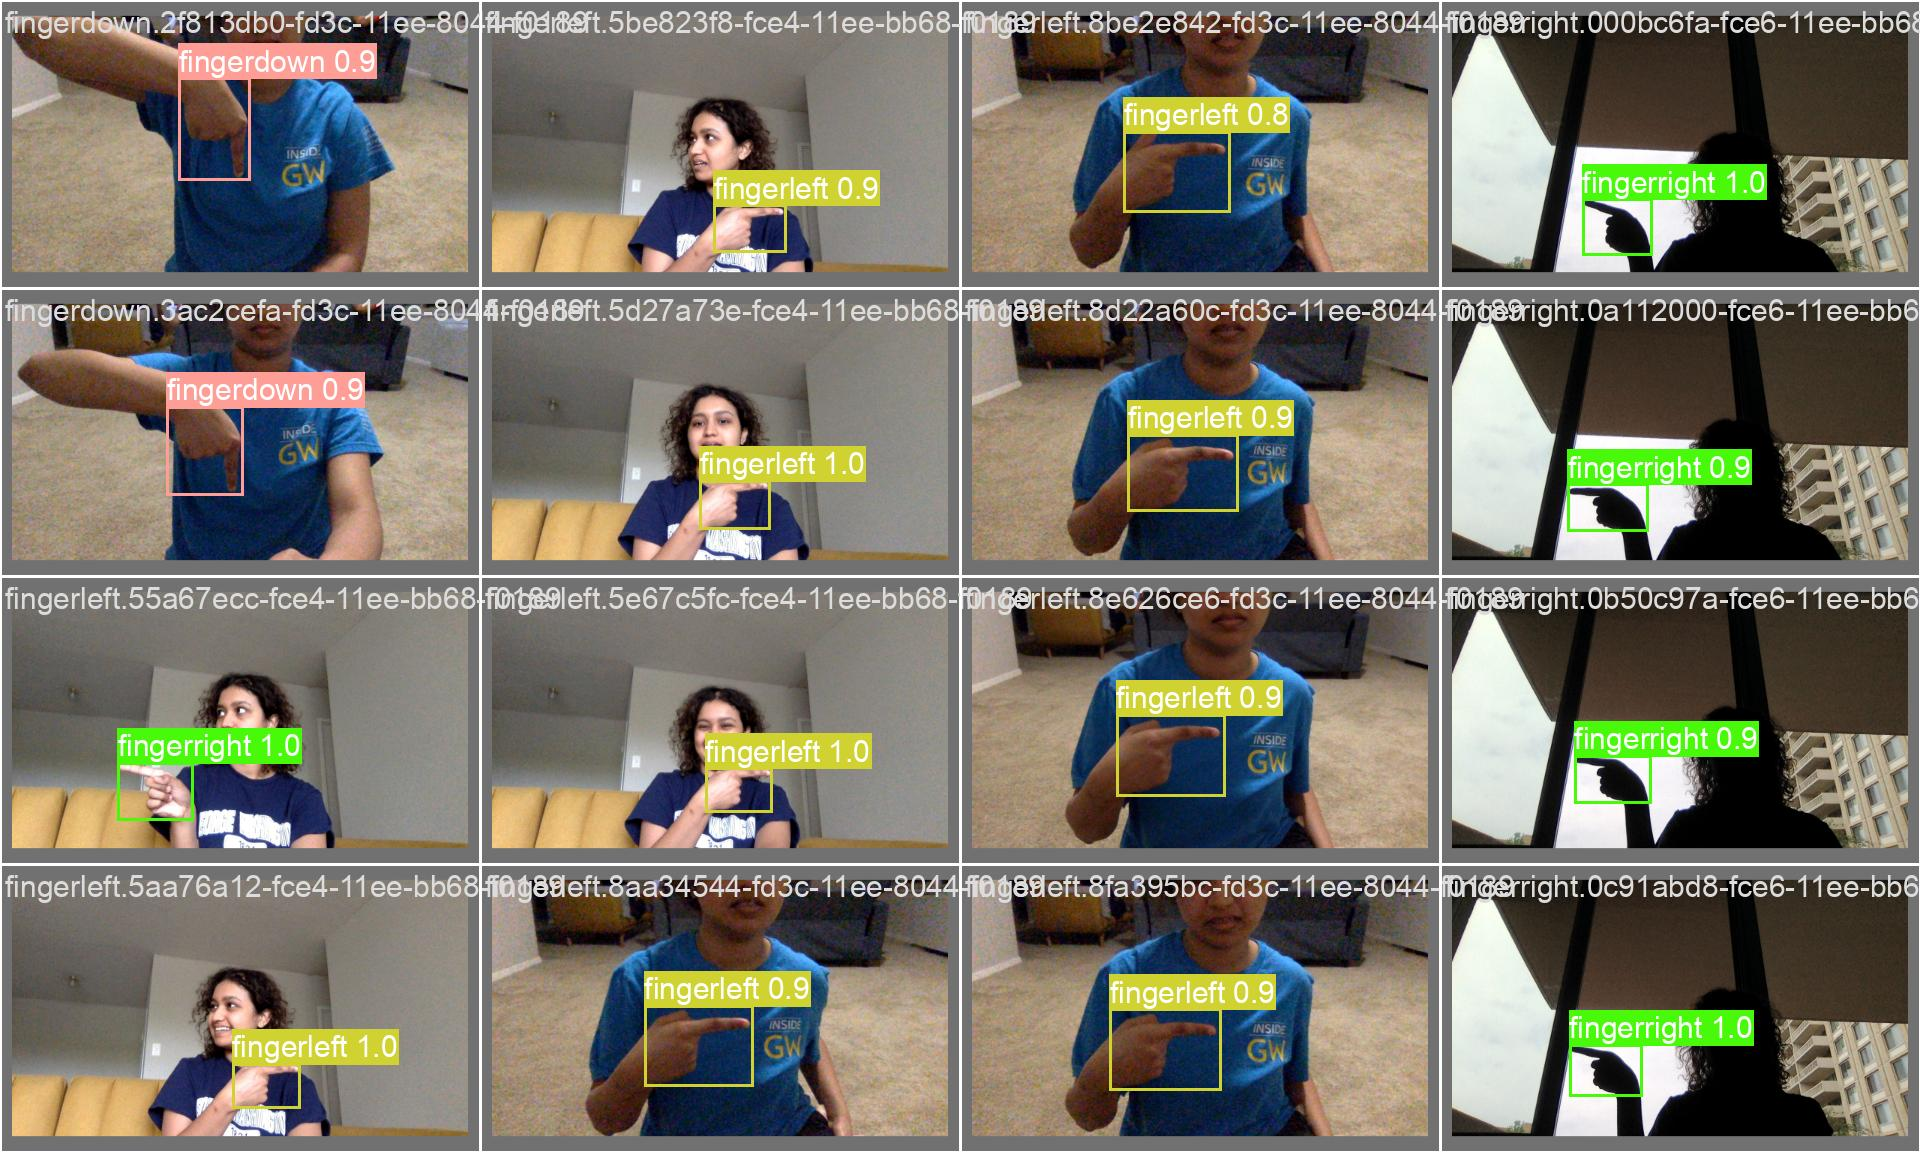

In [38]:

Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch1_pred.jpg', width=900)